<div style="text-align: center;">
    <h1><strong>UNIVERSIDAD POLITÉCNICA DE CARTAGENA</strong></h1>
    <h2><strong>GRADO EN CIENCIA E INGENIERÍA DE DATOS</strong></h2>

<div style="display:flex; justify-content:center; align-items:center; padding:5px;">
        <img src="imgs/upct_logo.png" style="height:300px; width:auto">
    </div>

<h2><strong>Procesamiento del Lenguaje Natural</strong></h2>

<h3><strong>PROYECTO</strong><br>
    <strong>Reddit Insights: Aplicación PLN para diversos análisis textuales avanzados.</strong></h3>

<p><strong>ESTUDIANTES</strong></p>
    <ul style="list-style-type:none; padding: 0;">
        <li><strong>Rubén Gil Martínez<strong></li>
        <li><strong>Guillermo López Pérez<strong></li>
    </ul>
</div>


**LIBRERÍAS**

In [1]:
!pip install praw
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" 

In [ ]:
# Instalamos gensim
!pip3 install -U gensim
# Instalamos fasttext
!pip install fasttext
!pip install -U sentence-transformers==2.7.0 transformers==4.39.3 huggingface-hub==0.27.0
!pip install -U bitsandbytes

In [ ]:
import pandas as pd
import numpy as np
import requests
import json
import csv
import datetime as dt
import time

import praw
import pandas as pd
from datetime import datetime
import time
import re
import os


from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, AutoTokenizer, AutoModelForSeq2SeqLM, BitsAndBytesConfig, AutoModelForCausalLM
from datasets import Dataset
import torch

from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

c:\Users\ruben\miniconda3\envs\NLP_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1) Compilación del corpus de comentarios de Reddit a través de su API y uso de Procesamiento Léxico:

In [ ]:
# Configuración de credenciales
reddit = praw.Reddit(
    client_id='client_id_here',
    client_secret='client_secret_here',
    user_agent='dl-pln-2025-RGM-GLP'
)

In [ ]:
# Prueba simple de correcta autenticación
try:
    # Intenta acceder a tu nombre de usuario para verificar autenticación
    print(f"Autenticado como: {reddit.user.me()}")

    # Prueba una solicitud simple
    for submission in reddit.subreddit("test").hot(limit=1):
        print(f"Título del post de prueba: {submission.title}")

    print("¡Autenticación exitosa!")

except Exception as e:
    print(f"Error de autenticación: {type(e).__name__} - {str(e)}")
    print("Por favor, verifica tus credenciales y la configuración de la aplicación.")

Autenticado como: None
Título del post de prueba: Some test commands
¡Autenticación exitosa!


In [ ]:
# Lista de subreddits a extraer
subreddits = ['Economics', 'books', 'travel', 'gaming', 'EnglishLearning', 'Design']

# Expresiones regulares para filtrado
url_pattern = re.compile(r'(https?://\S+)')
email_pattern = re.compile(r'[\w\.-]+@[\w\.-]+')

# Función para verificar si un comentario es válido
def is_valid_comment(text):
    if len(text) < 30:  # Mínimo de 30 caracteres
        return False

    # Eliminar URLs y emails
    text_cleaned = url_pattern.sub(' ', text)
    text_cleaned = email_pattern.sub(' ', text_cleaned)

    # Verificar si queda suficiente contenido
    return len(text_cleaned.strip()) >= 30

**EXTRACCIÓN DEL CORPUS DE COMENTARIOS EN ARCHIVOS JSON INDIVIDUALES PARA CADA SUBREDDIT**

- 6 subreddits distintos
- 20 hilos distintos de cada subreddit
- Alrededor de 50 comentarios por cada hilo

Durante la extracción hemos tenido en cuenta el evitar duplicados, tomar comentarios distribuidos en el tiempo (hemos tomado desde comentarios de la última semana hasta comentarios de otros años), tomar comentarios que no sean muy cortos y que además no contengan ni urls ni gmails ya que estos no aportan información relevante.

Parte de este filtrado de comentarios ha sido posible gracias a la función is_valid_comment() previamente definida.

In [ ]:
# Procesamiento de cada subreddit
'''for subreddit_name in subreddits:
    print(f"Procesando subreddit: {subreddit_name}...")

    subreddit_data = {
        "subreddit_name": subreddit_name,
        "threads": []
    }

    subreddit = reddit.subreddit(subreddit_name)
    threads_collected = 0  # Contador de hilos extraídos
    extracted_thread_ids = set()  # Para evitar duplicados

    # Diferentes filtros de tiempo
    time_filters = ['all', 'week', 'month', 'year']

    for time_filter in time_filters:
        if threads_collected >= 20:
            break

        print(f"  Extrayendo de {subreddit_name} con filtro: {time_filter}")

        try:
            threads = list(subreddit.top(time_filter=time_filter, limit=8))  # Procesamos 8 hilos para cada temporalidad para mayor rapidez y evitar bloqueos

            for thread in threads:
                if threads_collected >= 20 or thread.id in extracted_thread_ids:  # Evitar duplicados
                    continue

                print(f"    Procesando hilo: {thread.title}")

                # Información del hilo
                thread_info = {
                    "thread_id": thread.id,
                    "title": thread.title,
                    "author": str(thread.author),
                    "created_utc": datetime.utcfromtimestamp(thread.created_utc).isoformat(),
                    "score": thread.score,
                    "url": thread.url,
                    "permalink": thread.permalink,
                    "time_filter": time_filter,
                    "subreddit_name": subreddit_name,
                    "comments": []
                }


                # Extraer comentarios
                try:
                    thread.comments.replace_more(limit=3)  # Evita cargar demasiados comentarios
                    flat_comments = thread.comments.list()
                except Exception as e:
                    print(f"      Error al cargar comentarios: {e}")
                    continue

                valid_comments_count = 0

                for comment in flat_comments:
                    if valid_comments_count >= 50:
                        break

                    if is_valid_comment(comment.body): # Si el comentario pasa el filtro de validez es almacenado en la lista de comentarios de su respectivo hilo

                        comment_info = {
                            'comment_id': comment.id,
                            'author': str(comment.author),
                            'text': comment.body,
                            'score': comment.score,
                            'created_utc': datetime.utcfromtimestamp(comment.created_utc).isoformat(),
                            'subreddit_name': subreddit_name,
                            'thread_id': thread.id,
                            'is_submitter': comment.is_submitter,
                            'permalink': comment.permalink
                        }

                        thread_info["comments"].append(comment_info)
                        valid_comments_count += 1

                if valid_comments_count >= 25:  # Mínimo de 25 comentarios válidos, sino, el hilo es descartado
                    subreddit_data["threads"].append(thread_info)
                    extracted_thread_ids.add(thread.id)
                    threads_collected += 1
                    print(f"      Añadido con {valid_comments_count} comentarios válidos")
                else:
                    print(f"      Descartado: solo {valid_comments_count} comentarios válidos")

                time.sleep(1.5)  # Evitar exceso de peticiones a Reddit, nos permite cumplir con las normas de uso de la API y evitar bloqueos temporales

        except Exception as e:
            print(f"Error en {subreddit_name} con filtro {time_filter}: {e}")
            continue

    # Guardar en JSON
    os.makedirs('datasets', exist_ok=True)
    output_file = os.path.join('datasets', f"{subreddit_name}_data_3.0.json")

    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(subreddit_data, f, ensure_ascii=False, indent=2)

    print(f"Completado: {subreddit_name} - {threads_collected} hilos guardados en {output_file}\n")

print("Extracción completa.")'''


Procesando subreddit: Economics...
  Extrayendo de Economics con filtro: all
    Procesando hilo: Economist Warns That Elon Musk Is About to Cause a "Deep, Deep Recession"
      Añadido con 50 comentarios válidos
    Procesando hilo: 65% of Americans support monthly $2,000 COVID stimulus payments, new poll shows
      Añadido con 50 comentarios válidos
    Procesando hilo: Republicans Less Trusted on Economy Than Democrats For First Time in Years
      Añadido con 50 comentarios válidos
    Procesando hilo: Trump's first 50 days mark one of the worst starts for the S&P 500 under any presidency
      Añadido con 50 comentarios válidos
    Procesando hilo: US tourism to suffer huge '£49 billion drop' under Donald Trump
      Añadido con 50 comentarios válidos
    Procesando hilo: Fed report finds 75% of $800 billion Paycheck Protection Program didn't reach employees
      Añadido con 30 comentarios válidos
    Procesando hilo: Trudeau announces Canada ban on Russian oil imports. “Today, 

**PROCESAMIENTO LÉXICO Y CREACIÓN DE UN DATAFRAME PARA TRATAR CON MAYOR FACILIDAD LOS COMENTARIOS**

In [ ]:
from symspellpy import SymSpell, Verbosity
import spacy

# Cargamos el modelo de spaCy para realizar la Lematización
nlp = spacy.load('en_core_web_sm')

# Configuración de SymSpell para realizar la corrección automática de errores ortográficos
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = "datasets/frequency_dictionary_en_82_765.txt"   
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1, separator=" ")


True

In [ ]:
def remove_emojis(text):
    # Patrón para detectar emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # símbolos & pictogramas
        u"\U0001F680-\U0001F6FF"  # símbolos de transporte & mapas
        u"\U0001F1E0-\U0001F1FF"  # banderas (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

**FUNCIÓN DE PROCESAMIENTO LÉXICO**

In [ ]:
def preprocess_text(text, autocorrect=True, stopwords=True):
    # Eliminar emojis
    text = remove_emojis(text)

    # Convertimos a minúsculas
    text = text.lower()

    # Procesamiento con spaCy
    doc = nlp(text)

    # Tokenización y eliminación de signos de puntuación y números
    tokens = [token.text for token in doc if not token.is_punct and not token.like_num]

    # Corrección ortográfica con SymSpellPy
    if autocorrect:
        corrected_tokens = []
        for token in tokens:
            suggestions = sym_spell.lookup(token, Verbosity.CLOSEST, max_edit_distance=2)
            # Si hay sugerencias, tomamos la primera
            # Si no, mantenemos el token original
            if suggestions:
                corrected_tokens.append(suggestions[0].term)
            else:
                corrected_tokens.append(token)
        tokens = corrected_tokens

    # Eliminación de stopwords
    if stopwords:
        # Usamos el vocabulario de spaCy para eliminar stopwords
        tokens = [token for token in tokens if not token in nlp.Defaults.stop_words]

    # Lematización con spaCy
    doc = nlp(' '.join(tokens))
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

## Procesamiento Léxico con spaCy y SymSpellPy

Usamos **spaCy** para el procesamiento completo del texto. Aprovechamos sus capacidades integradas para:

- Tokenización  
- Detección de números y puntuación  
- Uso de su propia lista de *stopwords*  
- Lematización más precisa  

Además, realizamos la **corrección ortográfica** con **SymSpellPy**.

### Ventajas de usar spaCy

El proceso es más eficiente porque spaCy está optimizado para procesamiento de texto. La lematización con spaCy suele ser más precisa que con NLTK porque:

- Considera el contexto de la palabra  
- Tiene mejor manejo de formas irregulares  
- Está más actualizado con el lenguaje moderno  
- Es más rápido en el procesamiento  




**REALIZACIÓN DEL PROCESAMIENTO Y PREPARACIÓN DE LOS COMENTARIOS PARA SU POSTERIOR USO EN DIVERSAS TAREAS:**

In [ ]:
# Cargamos los datos extraídos y procesamos los comentarios
all_comments = []
dataset_path = 'datasets'

for filename in os.listdir(dataset_path):
    if filename.endswith('_data_3.0.json'):
        with open(os.path.join(dataset_path, filename), 'r', encoding='utf-8') as file:
            data = json.load(file)

            for thread in data['threads']:
                for comment in thread['comments']:
                    comment_data = {
                        'body': comment['text'],
                        'score': comment['score'],
                        'created_utc': comment['created_utc'],
                        'thread_title': thread['title'],
                        'subreddit': data['subreddit_name'],
                        'processed_text': preprocess_text(comment['text'], autocorrect=True, stopwords=True),
                        'processed_text_with_stopwords': preprocess_text(comment['text'], autocorrect=True, stopwords=False)
                    }
                    all_comments.append(comment_data)

**CREACIÓN DE UN DATAFRAME CON TODOS LOS COMENTARIOS EXTRAÍDOS Y POSTERIOR GUARDADO PARA SU USO REPETIDO DURANTE EL DESARROLLO DEL PROYECTO**

In [ ]:
print(len(all_comments))  # Obtención de alrededor de 6000 comentarios válidos

5880


In [ ]:
# Crear DataFrame
df_comments = pd.DataFrame(all_comments)

# Guardar el DataFrame en un archivo CSV
df_comments.to_csv('datasets/comments_data_3.0.csv', header=True, index=False, encoding='utf-8')


# Desarrollo de la parte intelectual del **Proyecto**:

In [2]:
df_comments = pd.read_csv('datasets/comments_data_3.0.csv', encoding='utf-8', sep=',', header=0)
df_comments.head()

,body,score,created_utc,thread_title,subreddit,processed_text,processed_text_with_stopwords
0,"So if you haven't already, there's a bot you c...",2474,2017-11-22T01:50:57,Join the Battle for Net Neutrality!! We need t...,books,bot text help write email fax free charge sena...,so if you have not already there be a bot you ...
1,Aussie here. Please fight for this. If the US ...,698,2017-11-22T03:19:54,Join the Battle for Net Neutrality!! We need t...,books,aussie fight lose net neutrality overflow,aussie here please fight for this if the us lo...
2,Why do we have to do this every few months? 😞,809,2017-11-22T03:17:01,Join the Battle for Net Neutrality!! We need t...,books,month,why do we have to do this every few month
3,💰 The 💰 intent 💰 is 💰 to 💰 provide 💰 consumers...,873,2017-11-22T02:21:54,Join the Battle for Net Neutrality!! We need t...,books,intent provide consumer high quality service s...,a the a intent a be a to a provide a consumer ...
4,Someone suggested that we flood Trumps twitter...,125,2017-11-22T04:41:47,Join the Battle for Net Neutrality!! We need t...,books,suggest flood trump twitter sweet save net neu...,someone suggest that we flood trump twitter wi...


**PROCESADO DE CAMPOS CON VALORES NULOS**

In [3]:
# Vemos si hay valores nulos en el DataFrame
print(df_comments.isnull().sum())

body                             0
score                            0
created_utc                      0
thread_title                     0
subreddit                        0
processed_text                   4
processed_text_with_stopwords    0
dtype: int64


In [4]:
df_comments["processed_text"] = df_comments["processed_text"].fillna("")

print(df_comments.isnull().sum())

body                             0
score                            0
created_utc                      0
thread_title                     0
subreddit                        0
processed_text                   0
processed_text_with_stopwords    0
dtype: int64


# 2) Clasificador de comentarios en Subreddits:

**CREAMOS LOS CONJUNTOS DE ENTRENAMIENTO Y TEST TENIENDO EN CUENTA LA CORRECTA ESTRATIFICACIÓN DE LOS COMENTARIOS**

Esta estratificación es clave para que en ambas particiones se mantega la distribución de etiquetas para cada subreddit evitando así posibles sesgos.

In [5]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_comments, test_size=0.3, random_state=2025, stratify=df_comments['subreddit'])


In [6]:
df_train.shape, df_test.shape

((4116, 7), (1764, 7))

In [ ]:
df_train['subreddit'].value_counts() # Muestra de la correcta estratificación de los datos

subreddit
gaming             700
EnglishLearning    700
travel             698
books              693
Economics          676
Design             649
Name: count, dtype: int64

In [ ]:
df_test['subreddit'].value_counts()

subreddit
gaming             300
EnglishLearning    300
travel             299
books              297
Economics          290
Design             278
Name: count, dtype: int64

# Desarrollo de Funciones de Entrenamiento Generalizadas

Para optimizar nuestro flujo de trabajo y asegurar la consistencia en los experimentos, procederemos a desarrollar un conjunto de **funciones de entrenamiento y evaluación generalizadas**. Estas funciones encapsularán la lógica para entrenar cada uno de nuestros enfoques de modelado (Representaciones Tradicionales y Word Embeddings) y evaluar su rendimiento.

El objetivo principal es crear componentes reutilizables que nos permitan:

1.  **Aplicar fácilmente los mismos procesos de entrenamiento y evaluación** a diferentes conjuntos de datos (texto crudo, texto preprocesado con stopwords, texto procesado sin stopwords y texto procesado con n-grams).
2.  **Modificar centralizadamente los parámetros** de los vectorizadores, transformadores y clasificadores para realizar ajustes finos y experimentos.
3.  **Reducir la duplicación de código**, haciendo nuestro notebook o scripts más limpios, legibles y mantenibles.
4.  **Generar informes de resultados y visualizaciones (como matrices de confusión) de manera estandarizada** para cada modelo y configuración probada.


Posteriormente realizaremos el entrenamiento(Fine Tunning) de un modelo de Hugging Face previamente entrenado y evaluaremos también su rendimiento. No lo metemos en este desarrollo de funciones porque solo será entrenado con texto sin procesar ya que este tipo de modelos pre-entrenados utilizan tokenizadores avanzados (como WordPiece para distilbert-base-uncased) que pueden manejar palabras desconocidas o raras descomponiéndolas en unidades más pequeñas (sub-palabras). Aún así, si que le daremos algún procesamiento superficial como la eliminación de URLs y gmail o el paso de las palabras a minúscula.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from BM25_Trans import BM25Transformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

**1) Entrenamiento de modelos con Representación Tradicional:**

**Función: `train_evaluate_traditional_models`**

Diseñamos esta función para entrenar y evaluar rápidamente modelos que usan las representaciones tradicionales. Comparamos tres representaciones: **TF**, **TF-IDF** y **BM25**, todas con un clasificador **SVM**.

**En resumen, hacemos esto:**

1.  **Configuramos pipelines** para cada representación (TF, TF-IDF, BM25) seguida de un SVM. Permitimos personalizar los parámetros de cada paso.
2.  **Iteramos** sobre estos pipelines:
    -   **Entrenamos** el modelo con `X_train`, `y_train`.
    -   **Evaluamos** con `X_test`, `y_test`, mostrando accuracy, un reporte de clasificación y una matriz de confusión.
3.  **Devolvemos** los modelos entrenados para su posible uso posterior.



In [8]:
def train_evaluate_traditional_models(X_train, y_train, X_test, y_test,
                                      bm25_transformer_class,
                                      model_suffix="",
                                      cv_params=None, # Parámetros para CountVectorizer
                                      tf_params_svc=None, # Parámetros para SVC en pipeline TF
                                      tfidf_params_svc=None, # Parámetros para SVC en pipeline TF-IDF
                                      bm25_params_svc=None, # Parámetros para SVC en pipeline BM25
                                      bm25_transformer_params=None # Parámetros para BM25Transformer
                                      ):


    # Parámetros por defecto si no se proporcionan:
    if cv_params is None:
        cv_params = {} # CountVectorizer usará sus propios defaults, como ngram_range=(1,1), después modificaremos este parámetros para trabajar también con bigramas y trigramas
    if tf_params_svc is None:
        tf_params_svc = {'kernel': 'rbf', 'random_state': 2025, 'tol': 1e-5, 'probability': True}
    if tfidf_params_svc is None:
        tfidf_params_svc = {'kernel': 'poly', 'random_state': 2025, 'tol': 1e-4, 'C': 2, 'degree': 2, 'probability': True}
    if bm25_params_svc is None:
        bm25_params_svc = {'kernel': 'poly', 'random_state': 2025, 'C': 2, 'degree': 2, 'tol': 1e-5, 'probability': True}
    if bm25_transformer_params is None:
        bm25_transformer_params = {'k': 1.2, 'b': 0.5}


    # Creación de los Pipelines de generación de modelos para cada representación:
    classifiers_config = {
        "TF": Pipeline([
            ('vect', CountVectorizer(**cv_params)),
            ('tf', TfidfTransformer(use_idf=False)), # use_idf=False para TF normalizado
            ('clf', SVC(**tf_params_svc))
        ]),
        "TF-IDF": Pipeline([
            ('vect', CountVectorizer(**cv_params)),
            ('tfidf', TfidfTransformer()), # use_idf=True por defecto para TF-IDF
            ('clf', SVC(**tfidf_params_svc))
        ]),
        "BM25": Pipeline([
            ('vect', CountVectorizer(**cv_params)),
            ('bm25', bm25_transformer_class(**bm25_transformer_params)),
            ('clf', SVC(**bm25_params_svc))
        ])
    }

    trained_classifiers = {}
    # Obtener todas las etiquetas únicas para el informe de clasificación y la matriz de confusión
    all_labels = sorted(list(y_train.unique()))


    # Entrenamiento y evaluación de cada clasificador:
    for name, classifier in classifiers_config.items():
        print(f"Entrenando {name} {model_suffix}...")
        classifier.fit(X_train, y_train)
        trained_classifiers[name] = classifier

        print(f"\nEvaluando {name} {model_suffix}...")
        predicted = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, predicted)

        print(f"Resultados {name} {model_suffix} ----- Accuracy: {accuracy:.4f}")
        print(classification_report(y_test, predicted, labels=all_labels, zero_division=0))
        print('=' * 60)


        # Muestra de la matriz de confusión
        try:
            fig, ax = plt.subplots(figsize=(max(8, len(all_labels)), max(6, len(all_labels)*0.8))) # Ajustar tamaño dinámicamente
            ConfusionMatrixDisplay.from_predictions(
                y_test,
                predicted,
                labels=all_labels, # Asegurar que todas las clases se muestren
                normalize='true', # Normalizar por fila
                xticks_rotation=45,
                ax=ax,
                cmap=plt.cm.Blues # Mapa de colores
            )
            ax.set_title(f'Matriz de Confusión:{name} {model_suffix}')

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"No se pudo graficar la matriz de confusión para {name}: {e}")
            print("Asegúrate de que y_test y predicted no estén vacíos y que matplotlib funcione correctamente.")


    return trained_classifiers

**2) Entrenamiento de modelos con Word Embeddings:**

**Función: `generate_ngrams_from_processed_text`**

*   **Entrada:** Texto ya procesado.
*   **Acción Principal:**
    *   Conserva las palabras originales (unigramas).
    *   Crea bigramas (pares de palabras unidas por `_`)
    *   Crea trigramas (tríos de palabras unidas por `_`)
*   **Salida:** Una única cadena de texto con todos estos elementos (unigramas, bigramas, trigramas) juntos, separados por espacios.
   
*   **Objetivo:** Enriquecer el texto con frases cortas (n-gramas) para poder calcular word_embeddings de combinación de palabras, comprobaremos si nos pueden aportar mayor información semántica a la hora de usar esos embeddings como características.

Esta función es clave para generar los bigramas y trigramas pudiendo así entrenar un Random Forest mediante **Word Embeddings** que incluyen una información que, esperemos, sea de mayor utilidad y que aporte una mayor semántica que solo los unigramas.

Hemos tenido que desarrollar esta función porque GLoVe no tiene ninguna funcionalidad para obtener embeddings de bigramas o trigramas cogiendo pares y tríos de palabras previamente procesados, GLoVe fue entrenado para extraer el **Word Embeddings** a nivel de unigrama, por tanto, hemos definido una función posterior para obtener un embdedding global del comentario a partir del promedio de todos los embeddings de los tokens que lo conforman. Lo veremos con mayor claridad en la construcción de los modelos que utilizan estos **Word Embeddings** como características.

In [9]:
def generate_ngrams_from_processed_text(
    processed_text,
    include_unigrams = True,
    include_bigrams = True,
    include_trigrams = True,
    ngram_join_char = '_'
) -> str:

    if not isinstance(processed_text, str) or not processed_text.strip():
        return ""

    unigram_tokens = processed_text.split() # Divide la cadena en tokens

    if not unigram_tokens: # Si después de split no hay tokens (ej. solo espacios en blanco)
        return ""

    final_feature_list = []

    # 1. Añadir Unigramas (si se especifica)
    if include_unigrams:
        final_feature_list.extend(unigram_tokens)

    # 2. Generar y añadir Bigramas (si se especifica)
    if include_bigrams and len(unigram_tokens) >= 2:
        bigrams = [
            ngram_join_char.join(unigram_tokens[i:i+2])
            for i in range(len(unigram_tokens) - 1)
        ]
        final_feature_list.extend(bigrams)

    # 3. Generar y añadir Trigramas (si se especifica)
    if include_trigrams and len(unigram_tokens) >= 3:
        trigrams = [
            ngram_join_char.join(unigram_tokens[i:i+3])
            for i in range(len(unigram_tokens) - 2)
        ]
        final_feature_list.extend(trigrams)

    return ' '.join(final_feature_list)





# Generación de n-gramas para el texto procesado
df_comments['n-grams_text'] = df_comments['processed_text'].apply(
    lambda x: generate_ngrams_from_processed_text(x, include_unigrams=True, include_bigrams=True, include_trigrams=True, ngram_join_char='_')
)

In [10]:
# Ejemplo de la correcta generación de n-gramas
df_comments['n-grams_text'][0]

'bot text help write email fax free charge senator governor text resist ask question write thread week ago post message think great send net neutrality cornerstone innovation free speech democracy internet control internet remain hand people use day ability share information impediment critical progression technology science small business culture stand public protect net neutrality cd love credit user lose comment send fax politician want net neutrality stay share away seriously take minute time find bot facebook messenger resistant bot_text text_help help_write write_email email_fax fax_free free_charge charge_senator senator_governor governor_text text_resist resist_ask ask_question question_write write_thread thread_week week_ago ago_post post_message message_think think_great great_send send_net net_neutrality neutrality_cornerstone cornerstone_innovation innovation_free free_speech speech_democracy democracy_internet internet_control control_internet internet_remain remain_hand h

**Función: `train_model_with_embeddings`**

Con esta función, entrenamos un `RandomForestClassifier` usando embeddings de palabras para representar comentarios. Nos permitirá entrenar múltiples modelos con distintos textos (crudo, procesado con stopwords, procesado sin stopwords, procesado con bigramas y trigramas añadidos).

**¿Cómo obtenemos el embedding de un comentario?**

1.  Dividimos el comentario en tokens (palabras unigramas/n-gramas).
2.  Para cada token:
    *   Si está en el modelo de embeddings, en este caso será GLoVe-300d el modelo que vamos a utilizar, tomamos su vector.
    *   Si es un n-grama, comprobamos si está en el modelo, si no lo esta, intentamos promediar los embeddings de sus palabras individuales.
3.  El embedding final del comentario es el **promedio de todos los vectores de tokens válidos** que encontramos.
    *   Si no hay tokens válidos, usamos un vector de ceros de igual dimensión que los embeddigs generados por el modelo.

**Luego:**

1.  Preparamos `X` (embeddings) e `y` (etiquetas).
2.  Dividimos en entrenamiento/prueba.
3.  Entrenamos un `RandomForestClassifier`.
4.  Evaluamos el modelo mostrando el reporte de clasificación y matriz de confusión.
5. Devolvemos el modelo y resultados.

In [11]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


def train_model_with_embeddings(
    df,
    text_column='body',
    label_column = 'subreddit',
    embedding_model=None, # Modelo GloVe cargado
    embedding_dim = None, # Necesario si el modelo no puede proveerlo o para ceros
    test_size = 0.2,
    random_state = 2025,
    n_estimators = 200,
    ngram_join_char ='_', # Carácter usado en tus n-gramas formateados
    handle_ngrams_strategy = None # 'average_components' o None
):
    """
    Entrena un modelo RandomForest con embeddings promedio de texto,
    con manejo opcional de n-gramas para modelos tipo GloVe.

    Args:
        df (pd.DataFrame): DataFrame con los datos
        text_column (str): Nombre de la columna con el texto
        label_column (str): Nombre de la columna con las etiquetas
        embedding_model: Modelo de embeddings pre-cargado (e.g., Word2Vec/GloVe)
        embedding_dim (int): La dimensionalidad del embedding. Necesario si se usa
                             un vector de ceros para textos sin embeddings y el modelo
                             no puede proveer `vector_size` fácilmente.
        test_size (float): Proporción para el split de test
        random_state (int): Semilla para reproducibilidad
        n_estimators (int): Número de árboles para el RandomForest
        ngram_join_char (str): Carácter que une los tokens en un n-grama (ej. 'palabra1_palabra2')
        handle_ngrams_strategy (str): Cómo manejar los n-gramas.
                                      'average_components': si un token n-grama no está en el modelo,
                                                            intenta promediar los embeddings de sus componentes.
                                      None: trata todos los tokens como vienen.
    Returns:
        tuple: (modelo entrenado, reporte de clasificación, X_test, y_test)
    """

    # 1. Generación de embeddings
    def get_mean_embedding_with_ngram_handling(text):
        doc_vectors = []
        if not isinstance(text, str): # Manejar NaN u otros tipos
            return np.zeros(embedding_dim) if handle_ngrams_strategy else np.nan


        tokens = text.split()
        for token in tokens:
            # Si el token está en el modelo, lo añadimos a la lista de vectores
            if token in embedding_model:
                doc_vectors.append(embedding_model[token])

            # Si el token no está en el modelo y no es un n-grama, lo ignoramos, si es un n-grama procesamos sus componentes para ver si existen en el modelo, hacemos un promedio de los embeddings de sus componentes
            # y lo incorporamos a la lista de vectores
            elif handle_ngrams_strategy == 'average_components' and ngram_join_char in token:
                component_tokens = token.split(ngram_join_char)
                component_vectors = []
                for comp_token in component_tokens:
                    if comp_token in embedding_model:
                        component_vectors.append(embedding_model[comp_token])

                if component_vectors: # Si se encontraron embeddings para algunos componentes
                    doc_vectors.append(np.mean(component_vectors, axis=0))
            # else: token OOV y no es n-grama a procesar, o sus componentes son OOV. Se ignora

        if doc_vectors:
            return np.mean(doc_vectors, axis=0)
        else:
            # Devolver vector de ceros si handle_ngrams_strategy está activo y no hay vectores,
            # o np.nan si no (para filtrado posterior)
            return np.zeros(embedding_dim) if handle_ngrams_strategy == 'average_components' else np.nan


    # Aplicamos la función para obtener el Setence Embedding
    df_copy = df.copy()
    df_copy['embedding_mean'] = df_copy[text_column].apply(get_mean_embedding_with_ngram_handling)



    # 2. Preparación de datos
    # Si se usa np.nan, filtrar. Si se usa np.zeros, no es estrictamente necesario filtrar por notna()

    if handle_ngrams_strategy != 'average_components':
        valid_samples = df_copy['embedding_mean'].notna()

        if not valid_samples.any():
            print("Advertencia: Ninguna muestra tiene un embedding válido. No se puede entrenar.")
            return None, "No hay datos válidos para entrenar", None, None

        X = np.vstack(df_copy.loc[valid_samples, 'embedding_mean'].values)
        y = df_copy.loc[valid_samples, label_column]
    else: # Si se usó np.zeros para OOV, no debería haber NaNs de embedding

        embeddings_matrix = np.vstack(df_copy['embedding_mean'].values)

        X = embeddings_matrix
        y = df_copy[label_column]


    # 3. Split de datos
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    all_labels = sorted(list(y_train.unique()))

    # 4. Entrenamiento del modelo
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=random_state
    )
    # Entrenamos el modelo con los embeddings promedio
    rf.fit(X_train, y_train)


    # 5. Evaluación

    y_pred = rf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Resultados ----- Accuracy: {accuracy:.4f}")
    report_str = classification_report(y_test, y_pred, zero_division=0)
    report_dict = classification_report(y_test, y_pred, zero_division=0, output_dict=True)


    print("Entrenamiento completado")
    print("\n\nReporte de clasificación:")
    print(report_str)

    # Muestra de la matriz de confusión
    try:
        fig, ax = plt.subplots(figsize=(max(8, len(all_labels)), max(6, len(all_labels)*0.8)))
        ConfusionMatrixDisplay.from_predictions(
            y_test,
            y_pred,
            labels=all_labels, # Asegurar que todas las clases se muestren
            normalize='true', # Normalizar por clase
            xticks_rotation=45,
            ax=ax,
            cmap=plt.cm.Blues
        )
        ax.set_title(f'Matriz de Confusión:')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"No se pudo graficar la matriz de confusión. {e}")
        print("Asegúrate de que y_test y y_pred no estén vacíos y que matplotlib funcione correctamente.")

    return rf, report_dict, X_test, y_test

# Fase 1: Modelado con Texto No Procesado (Baseline)

En esta fase inicial, procederemos a desarrollar y entrenar nuestros dos enfoques de clasificación de texto (Representaciones Tradicionales y Word Embeddings ) utilizando los comentarios de Reddit en su **forma original, sin aplicar ningún preprocesamiento léxico avanzado**.

El objetivo de esta etapa es establecer una **línea base (baseline)** de rendimiento. Al entrenar los modelos con texto "crudo", podremos cuantificar de manera efectiva el impacto (positivo o negativo) de las técnicas de preprocesamiento que introduciremos en fases posteriores. Esto nos permitirá tomar decisiones informadas sobre qué pasos de limpieza y normalización son verdaderamente beneficiosos para nuestra tarea específica de clasificación de subreddits.

Los modelos que se entrenarán son:
1.  **Representaciones Tradicionales:** BoW,TF-IDF y BM25 con el clasificador SVC.
2.  **Word Embeddings:** GloVe Embeddings con el clasificador Random Forest.


**1) Modelos con Representación Tradicional (body):**

Entrenando TF ...

Evaluando TF ...
Resultados TF  ----- Accuracy: 0.6712
                 precision    recall  f1-score   support

         Design       0.64      0.61      0.62       278
      Economics       0.70      0.73      0.71       290
EnglishLearning       0.82      0.73      0.77       300
          books       0.64      0.59      0.61       297
         gaming       0.59      0.66      0.62       300
         travel       0.66      0.71      0.68       299

       accuracy                           0.67      1764
      macro avg       0.67      0.67      0.67      1764
   weighted avg       0.67      0.67      0.67      1764



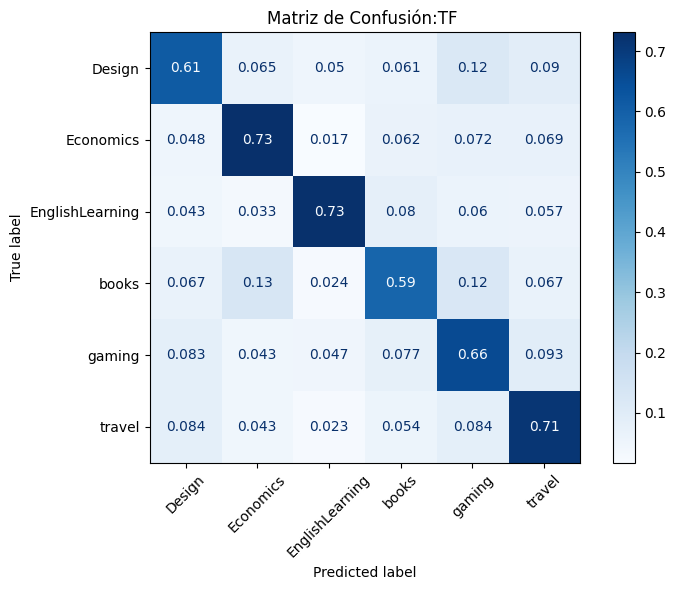

Entrenando TF-IDF ...

Evaluando TF-IDF ...
Resultados TF-IDF  ----- Accuracy: 0.7778
                 precision    recall  f1-score   support

         Design       0.78      0.72      0.75       278
      Economics       0.80      0.76      0.78       290
EnglishLearning       0.91      0.80      0.85       300
          books       0.70      0.73      0.72       297
         gaming       0.70      0.80      0.75       300
         travel       0.81      0.86      0.83       299

       accuracy                           0.78      1764
      macro avg       0.78      0.78      0.78      1764
   weighted avg       0.78      0.78      0.78      1764



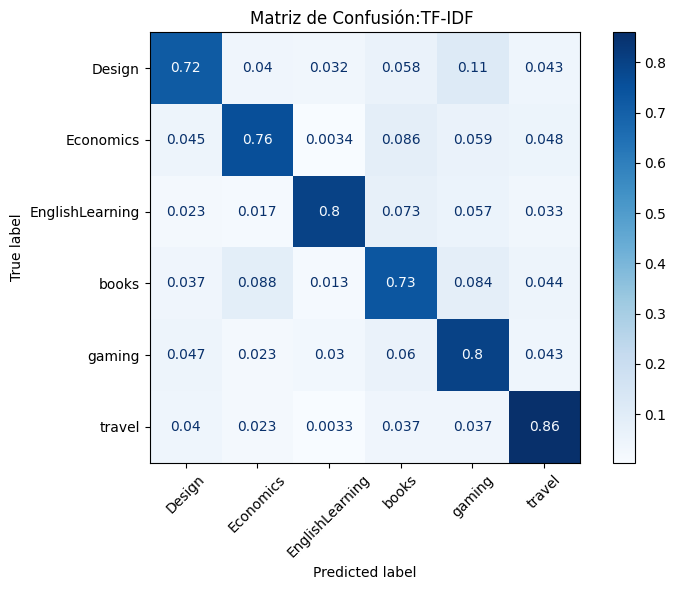

Entrenando BM25 ...

Evaluando BM25 ...
Resultados BM25  ----- Accuracy: 0.8027
                 precision    recall  f1-score   support

         Design       0.79      0.76      0.78       278
      Economics       0.83      0.82      0.82       290
EnglishLearning       0.93      0.81      0.86       300
          books       0.71      0.75      0.73       297
         gaming       0.77      0.80      0.78       300
         travel       0.81      0.88      0.84       299

       accuracy                           0.80      1764
      macro avg       0.81      0.80      0.80      1764
   weighted avg       0.81      0.80      0.80      1764



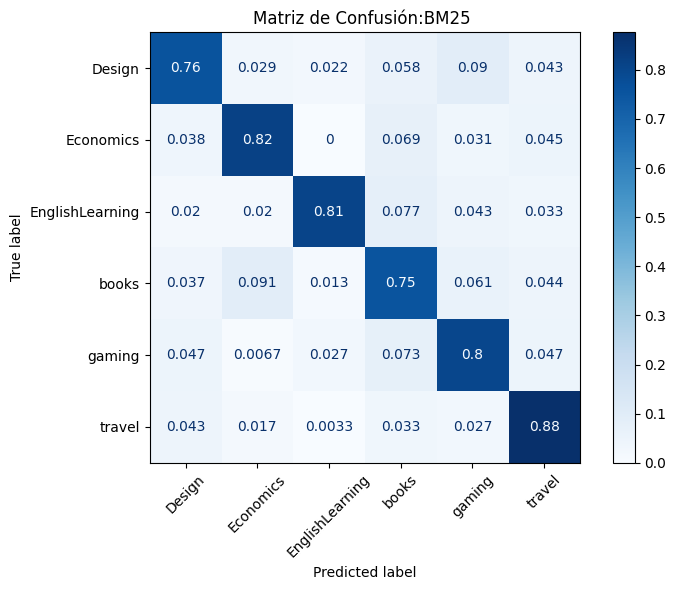

{'TF': Pipeline(steps=[('vect', CountVectorizer()),
                 ('tf', TfidfTransformer(use_idf=False)),
                 ('clf', SVC(probability=True, random_state=2025, tol=1e-05))]),
 'TF-IDF': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                 ('clf',
                  SVC(C=2, degree=2, kernel='poly', probability=True,
                      random_state=2025, tol=0.0001))]),
 'BM25': Pipeline(steps=[('vect', CountVectorizer()), ('bm25', BM25Transformer(b=0.5)),
                 ('clf',
                  SVC(C=2, degree=2, kernel='poly', probability=True,
                      random_state=2025, tol=1e-05))])}

In [13]:
train_evaluate_traditional_models(df_train['body'], df_train['subreddit'], df_test['body'], df_test['subreddit'],
                                      bm25_transformer_class=BM25Transformer,
                                      model_suffix="",
                                      cv_params=None, # Parámetros para CountVectorizer
                                      tf_params_svc=None, # Parámetros para SVC en pipeline TF
                                      tfidf_params_svc=None, # Parámetros para SVC en pipeline TF-IDF
                                      bm25_params_svc=None, # Parámetros para SVC en pipeline BM25
                                      bm25_transformer_params=None # Parámetros para BM25Transformer
                                      )

# Comentar que fijamos None porque no queremos cambiar los parámetros por defecto de los modelos, pero se pueden ajustar si se desea.

En este primer entrenamiento nos ha sorprendido mucho la información que nos brinda la representación de texto de `BoW BM25` a la hora de clasificar los comentarios, da un rendimiento cercano al máximo obtenido en modelos posteriores, a continuación lo veremos.

**2) Modelo con Word Embeddings (body):**

Como hemos comentado con anterioridad, vamos a utilizar el modelo de Embeddigs de **GLoVe**, específicamente utilizaremos el que contiene **Word Embeddings** de 300 dimensiones.

In [12]:
import gensim.downloader as api
model_GLoVe_300 = api.load("glove-wiki-gigaword-300")

Resultados ----- Accuracy: 0.5795
Entrenamiento completado


Reporte de clasificación:
                 precision    recall  f1-score   support

         Design       0.55      0.41      0.47       184
      Economics       0.66      0.74      0.70       193
EnglishLearning       0.59      0.64      0.62       199
          books       0.52      0.44      0.48       198
         gaming       0.53      0.62      0.57       197
         travel       0.61      0.62      0.62       199

       accuracy                           0.58      1170
      macro avg       0.58      0.58      0.57      1170
   weighted avg       0.58      0.58      0.57      1170



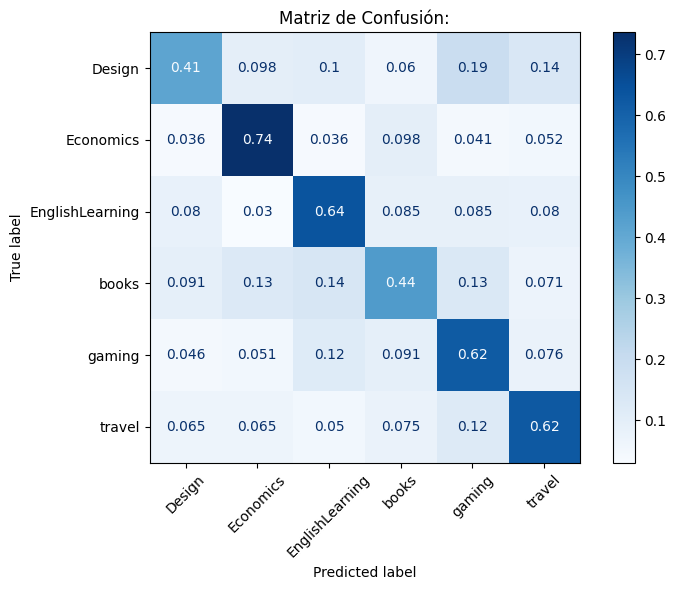

(RandomForestClassifier(n_estimators=200, random_state=2025),
 {'Design': {'precision': 0.5467625899280576,
   'recall': 0.41304347826086957,
   'f1-score': 0.47058823529411764,
   'support': 184.0},
  'Economics': {'precision': 0.6635514018691588,
   'recall': 0.7357512953367875,
   'f1-score': 0.6977886977886978,
   'support': 193.0},
  'EnglishLearning': {'precision': 0.5934579439252337,
   'recall': 0.6381909547738693,
   'f1-score': 0.6150121065375302,
   'support': 199.0},
  'books': {'precision': 0.5209580838323353,
   'recall': 0.4393939393939394,
   'f1-score': 0.4767123287671233,
   'support': 198.0},
  'gaming': {'precision': 0.5258620689655172,
   'recall': 0.6192893401015228,
   'f1-score': 0.5687645687645687,
   'support': 197.0},
  'travel': {'precision': 0.6078431372549019,
   'recall': 0.6231155778894473,
   'f1-score': 0.6153846153846154,
   'support': 199.0},
  'accuracy': 0.5794871794871795,
  'macro avg': {'precision': 0.5764058709625342,
   'recall': 0.57813076429

In [14]:
train_model_with_embeddings(
    df_comments,
    text_column ='body',
    label_column ='subreddit',
    embedding_model = model_GLoVe_300, # Modelo GloVe cargado
    test_size = 0.2,
    random_state =2025,
    n_estimators =200,
    ngram_join_char ='_',
    handle_ngrams_strategy = None # 'average_components' o None
)

En este caso podemos comprobar que, el modelo basado en extracción de características a través de **Word Embedings**, consigue un rendimiento muy pobre, esto se debe en gran medida a que el texto no esta procesado y cuando le pasamos tokens no procesado al modelo de GLoVe para extraer su embedding específico, este no los identifica por lo que la mayoría de tokens no procesados contendrán el embedding asociado a los **OOV (Out of Vocabulary)**.

# Fase 2: Modelado con Texto Procesado

Tras establecer nuestra línea base, en esta segunda fase entrenaremos los dos sistemas de clasificación mediante dos nuevos modelos  utilizando los comentarios de Reddit después de haber sido sometidos a un **proceso de limpieza y normalización exhaustivo**.

Para ello, aplicaremos nuestra función `preprocess_text` a todo el corpus de comentarios **(body)**. Esta función realiza las siguientes operaciones:

```python
def preprocess_text(text, autocorrect=True):
    # Eliminar emojis
    text = remove_emojis(text)
    
    # Convertimos a minúsculas
    text = text.lower()
    
    # Procesamiento con spaCy para tokenización inicial
    doc = nlp(text)
    
    # Tokenización y eliminación de signos de puntuación y números
    tokens = [token.text for token in doc if not token.is_punct and not token.like_num]
    
    # Corrección ortográfica con SymSpellPy (opcional)
    if autocorrect:
        corrected_tokens = []
        for token in tokens:
            suggestions = sym_spell.lookup(token, Verbosity.CLOSEST, max_edit_distance=2)
            if suggestions:
                corrected_tokens.append(suggestions[0].term)
            else:
                corrected_tokens.append(token)
        tokens = corrected_tokens
    
    # Eliminación de stopwords utilizando la lista por defecto de spaCy
    tokens = [token for token in tokens if not token in nlp.Defaults.stop_words]
    
    # Lematización con spaCy (sobre los tokens ya filtrados)
    doc = nlp(' '.join(tokens))
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)
```



1.  **Eliminación de Emojis:** Se retiran todos los emojis del texto, no necesarios para esta tarea en específico pero para análisis de sentimiento sería clave dejarlos como un token más.
2.  **Conversión a Minúsculas:** Todo el texto se convierte a letras minúsculas.
3.  **Tokenización y Limpieza Inicial (con spaCy):**
    *   El texto se tokeniza.
    *   Se eliminan los signos de puntuación.
    *   Se eliminan los tokens que representan números.
4.  **Corrección Ortográfica (con SymSpellPy):** Si está activada, se intenta corregir cada token utilizando un diccionario y una distancia de edición máxima de 2. Se toma la sugerencia más probable.
5.  **Eliminación de Stopwords (con spaCy):** Se eliminan las palabras comunes (stopwords) utilizando la lista por defecto de spaCy.
6.  **Lematización (con spaCy):** Los tokens restantes se convierten a su forma base o lema.
7.  **Resultado:** Se devuelve una cadena de texto con los tokens preprocesados y unidos por espacios.

El objetivo es evaluar si este conjunto de técnicas de preprocesamiento mejora la capacidad de nuestros modelos para clasificar correctamente los comentarios en sus respectivos subreddits, comparando los resultados con la línea base obtenida en la Fase 1.

### Vamos a diferenciar el entrenamiento de modelos con texto procesado según si mantenemos o no las stopwords, según el tipo de representación que realicemos y la tarea para la que estemos trabajando, estas nos pueden ser también de utilidad para conseguir un mejor rendimiento.

- ### Vamos a entrenar ambos modelos con distinto tipo de representación mediante estos dos enfoques de procesado, compararemos sus rendimientos y trataremos de explicar porque funciona mejor o peor en los diferentes casos.

**1) Modelos Representación Tradicional (Texto procesado con mantenimiento de stopwords)**

Entrenando TF ...

Evaluando TF ...
Resultados TF  ----- Accuracy: 0.6825
                 precision    recall  f1-score   support

         Design       0.61      0.64      0.63       278
      Economics       0.69      0.76      0.72       290
EnglishLearning       0.81      0.74      0.77       300
          books       0.65      0.57      0.61       297
         gaming       0.62      0.65      0.63       300
         travel       0.72      0.74      0.73       299

       accuracy                           0.68      1764
      macro avg       0.68      0.68      0.68      1764
   weighted avg       0.68      0.68      0.68      1764



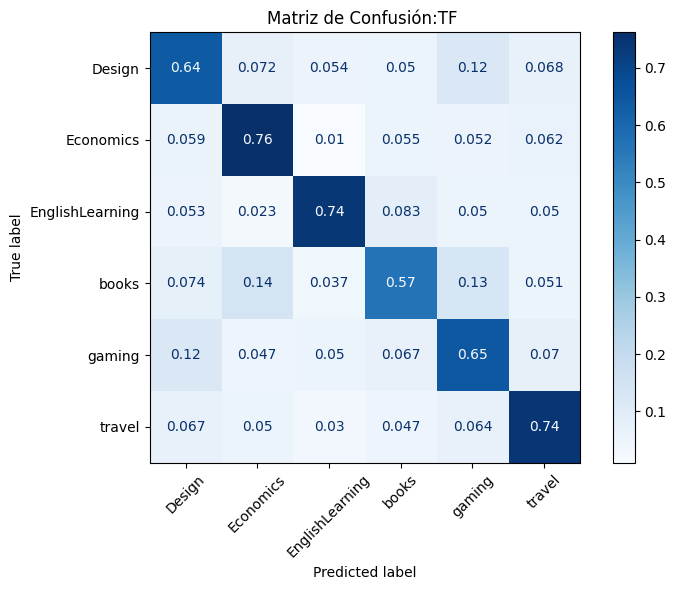

Entrenando TF-IDF ...

Evaluando TF-IDF ...
Resultados TF-IDF  ----- Accuracy: 0.7823
                 precision    recall  f1-score   support

         Design       0.71      0.74      0.72       278
      Economics       0.82      0.74      0.78       290
EnglishLearning       0.90      0.80      0.85       300
          books       0.74      0.75      0.75       297
         gaming       0.74      0.79      0.77       300
         travel       0.79      0.86      0.83       299

       accuracy                           0.78      1764
      macro avg       0.78      0.78      0.78      1764
   weighted avg       0.79      0.78      0.78      1764



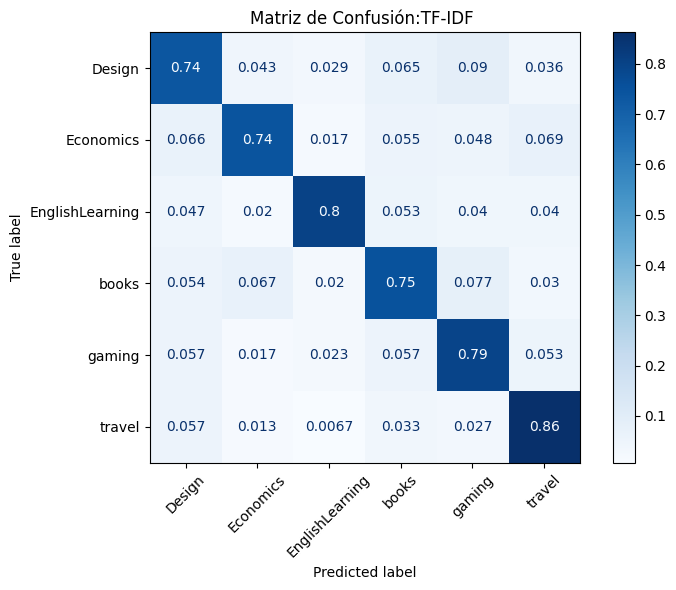

Entrenando BM25 ...

Evaluando BM25 ...
Resultados BM25  ----- Accuracy: 0.8146
                 precision    recall  f1-score   support

         Design       0.75      0.78      0.76       278
      Economics       0.86      0.82      0.84       290
EnglishLearning       0.92      0.83      0.87       300
          books       0.77      0.78      0.77       297
         gaming       0.81      0.79      0.80       300
         travel       0.80      0.89      0.84       299

       accuracy                           0.81      1764
      macro avg       0.82      0.81      0.81      1764
   weighted avg       0.82      0.81      0.82      1764



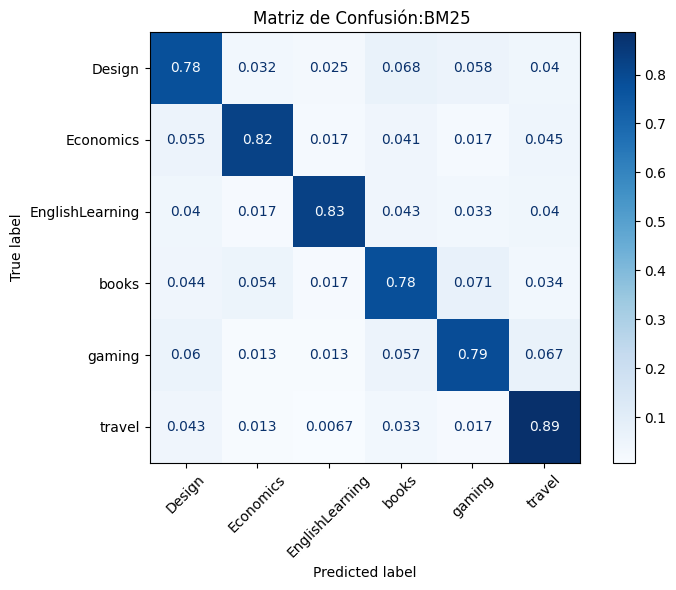

{'TF': Pipeline(steps=[('vect', CountVectorizer()),
                 ('tf', TfidfTransformer(use_idf=False)),
                 ('clf', SVC(probability=True, random_state=2025, tol=1e-05))]),
 'TF-IDF': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                 ('clf',
                  SVC(C=2, degree=2, kernel='poly', probability=True,
                      random_state=2025, tol=0.0001))]),
 'BM25': Pipeline(steps=[('vect', CountVectorizer()), ('bm25', BM25Transformer(b=0.5)),
                 ('clf',
                  SVC(C=2, degree=2, kernel='poly', probability=True,
                      random_state=2025, tol=1e-05))])}

In [15]:
train_evaluate_traditional_models(df_train['processed_text_with_stopwords'], df_train['subreddit'], df_test['processed_text_with_stopwords'], df_test['subreddit'],
                                      bm25_transformer_class=BM25Transformer,
                                      model_suffix="",
                                      cv_params=None, # Parámetros para CountVectorizer
                                      tf_params_svc=None, # Parámetros para SVC en pipeline TF
                                      tfidf_params_svc=None, # Parámetros para SVC en pipeline TF-IDF
                                      bm25_params_svc=None, # Parámetros para SVC en pipeline BM25
                                      bm25_transformer_params=None # Parámetros para BM25Transformer
                                      )

**1) Modelos Representación Tradicional (Texto procesado con eliminación de stopwords)**

Entrenando TF ...

Evaluando TF ...
Resultados TF  ----- Accuracy: 0.7489
                 precision    recall  f1-score   support

         Design       0.67      0.72      0.70       278
      Economics       0.81      0.77      0.79       290
EnglishLearning       0.82      0.73      0.77       300
          books       0.72      0.67      0.69       297
         gaming       0.69      0.77      0.73       300
         travel       0.79      0.83      0.81       299

       accuracy                           0.75      1764
      macro avg       0.75      0.75      0.75      1764
   weighted avg       0.75      0.75      0.75      1764



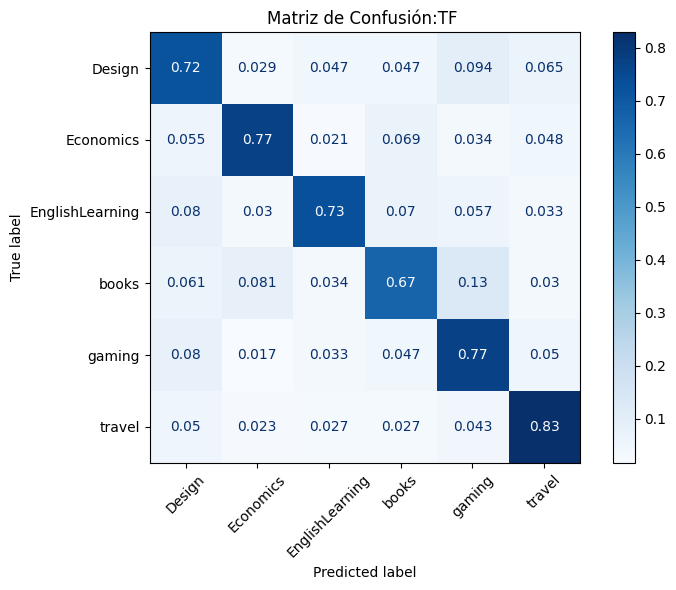

Entrenando TF-IDF ...

Evaluando TF-IDF ...
Resultados TF-IDF  ----- Accuracy: 0.7920
                 precision    recall  f1-score   support

         Design       0.72      0.75      0.73       278
      Economics       0.82      0.82      0.82       290
EnglishLearning       0.87      0.79      0.83       300
          books       0.74      0.78      0.76       297
         gaming       0.80      0.75      0.77       300
         travel       0.81      0.86      0.83       299

       accuracy                           0.79      1764
      macro avg       0.79      0.79      0.79      1764
   weighted avg       0.79      0.79      0.79      1764



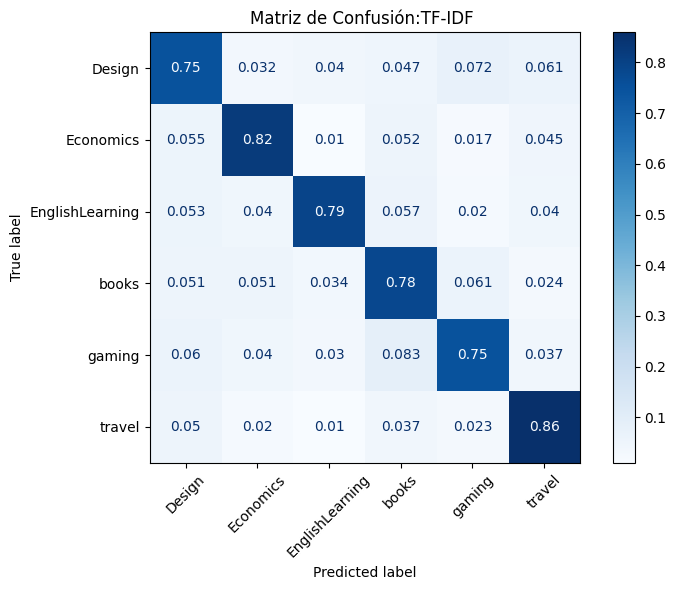

Entrenando BM25 ...

Evaluando BM25 ...
Resultados BM25  ----- Accuracy: 0.8056
                 precision    recall  f1-score   support

         Design       0.76      0.76      0.76       278
      Economics       0.83      0.85      0.84       290
EnglishLearning       0.87      0.81      0.84       300
          books       0.73      0.80      0.76       297
         gaming       0.81      0.75      0.78       300
         travel       0.83      0.87      0.85       299

       accuracy                           0.81      1764
      macro avg       0.81      0.81      0.81      1764
   weighted avg       0.81      0.81      0.81      1764



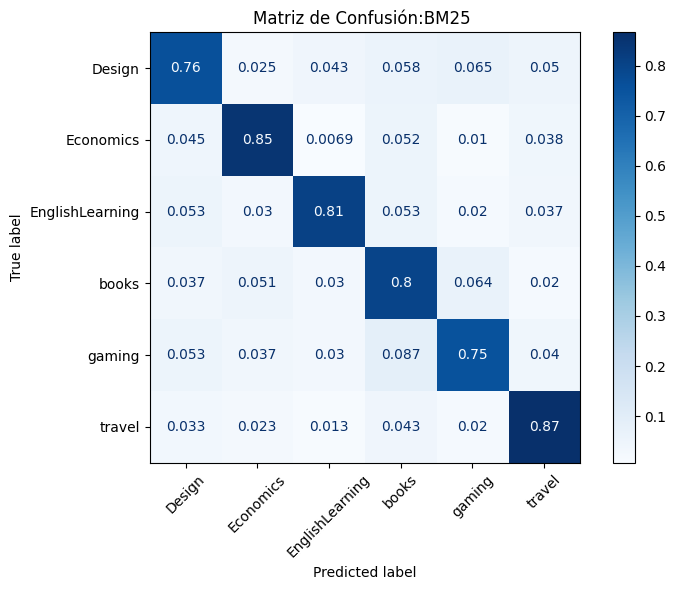

{'TF': Pipeline(steps=[('vect', CountVectorizer()),
                 ('tf', TfidfTransformer(use_idf=False)),
                 ('clf', SVC(probability=True, random_state=2025, tol=1e-05))]),
 'TF-IDF': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                 ('clf',
                  SVC(C=2, degree=2, kernel='poly', probability=True,
                      random_state=2025, tol=0.0001))]),
 'BM25': Pipeline(steps=[('vect', CountVectorizer()), ('bm25', BM25Transformer(b=0.5)),
                 ('clf',
                  SVC(C=2, degree=2, kernel='poly', probability=True,
                      random_state=2025, tol=1e-05))])}

In [16]:
train_evaluate_traditional_models(df_train['processed_text'], df_train['subreddit'], df_test['processed_text'], df_test['subreddit'],
                                      bm25_transformer_class=BM25Transformer,
                                      model_suffix="",
                                      cv_params=None, # Parámetros para CountVectorizer
                                      tf_params_svc=None, # Parámetros para SVC en pipeline TF
                                      tfidf_params_svc=None, # Parámetros para SVC en pipeline TF-IDF
                                      bm25_params_svc=None, # Parámetros para SVC en pipeline BM25
                                      bm25_transformer_params=None # Parámetros para BM25Transformer
                                      )

# Comentar que fijamos None porque no queremos cambiar los parámetros por defecto de los modelos, pero se pueden ajustar si se desea.

#### **Análisis de Modelos Basados en Representación Tradicional**


#### 1. Textos con Stopwords
- **TF y DF**: Se observa una **reducción en la capacidad clasificatoria**, posiblemente porque las stopwords añaden ruido, diluyendo la relevancia de las palabras clave.
- **BM25**: Muestra un **aumento en la capacidad predictiva**, con una mejora de unos pocos puntos porcentuales respecto al texto sin procesar. Esto sugiere que BM25 puede beneficiarse de la presencia de stopwords en ciertas configuraciones de pre-procesado.

#### 2. Textos sin Stopwords
- **TF y DF**: Consiguen una **mejora notable** en su rendimiento al eliminar las stopwords, lo que refuerza su dependencia de términos más informativos.
- **BM25**: La eliminación de stopwords parece tener un **impacto negativo** en su rendimiento, reduciendo la capacidad clasificatoria del modelo.

#### Conclusión
BM25 destaca cuando es entrenado con texto procesado que incluye:
- **Corrección ortográfica**
- **Lematización**
- **Eliminación de caracteres no deseados**
- Pero se mantiene el uso de **stopwords**.

Esto sugiere que las stopwords pueden ser útiles en BM25 al actuar como conectores contextuales, mejorando la capacidad del modelo para capturar relaciones importantes en el texto.

**2) Modelo con Word Embeddings (Texto procesado con mantenimiento de stopwords)**

Resultados ----- Accuracy: 0.6383
Entrenamiento completado


Reporte de clasificación:
                 precision    recall  f1-score   support

         Design       0.63      0.56      0.60       185
      Economics       0.69      0.77      0.73       193
EnglishLearning       0.68      0.73      0.71       199
          books       0.63      0.53      0.58       198
         gaming       0.54      0.56      0.55       200
         travel       0.64      0.67      0.66       200

       accuracy                           0.64      1175
      macro avg       0.64      0.64      0.64      1175
   weighted avg       0.64      0.64      0.64      1175



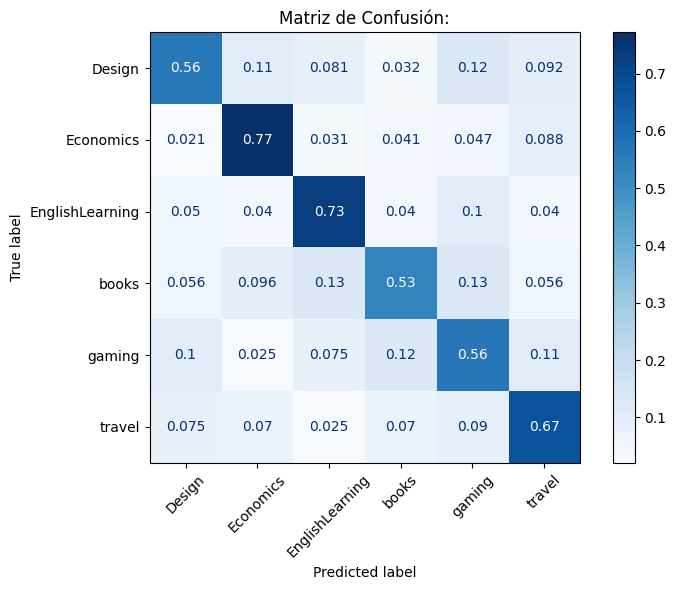

(RandomForestClassifier(n_estimators=200, random_state=2025),
 {'Design': {'precision': 0.6341463414634146,
   'recall': 0.5621621621621622,
   'f1-score': 0.5959885386819485,
   'support': 185.0},
  'Economics': {'precision': 0.6930232558139535,
   'recall': 0.772020725388601,
   'f1-score': 0.7303921568627451,
   'support': 193.0},
  'EnglishLearning': {'precision': 0.6839622641509434,
   'recall': 0.7286432160804021,
   'f1-score': 0.7055961070559611,
   'support': 199.0},
  'books': {'precision': 0.6325301204819277,
   'recall': 0.5303030303030303,
   'f1-score': 0.5769230769230769,
   'support': 198.0},
  'gaming': {'precision': 0.5406698564593302,
   'recall': 0.565,
   'f1-score': 0.5525672371638142,
   'support': 200.0},
  'travel': {'precision': 0.6411483253588517,
   'recall': 0.67,
   'f1-score': 0.6552567237163814,
   'support': 200.0},
  'accuracy': 0.6382978723404256,
  'macro avg': {'precision': 0.6375800272880702,
   'recall': 0.6380215223223659,
   'f1-score': 0.636120

In [17]:
train_model_with_embeddings(
    df_comments,
    text_column ='processed_text_with_stopwords',
    label_column ='subreddit',
    embedding_model = model_GLoVe_300, # Modelo GloVe cargado
    test_size = 0.2,
    random_state =2025,
    n_estimators =200,
    ngram_join_char ='_',
    handle_ngrams_strategy = None # 'average_components' o None
)

**2) Modelo con Word Embeddings (Texto procesado con eliminación de stopwords)**

Resultados ----- Accuracy: 0.6854
Entrenamiento completado


Reporte de clasificación:
                 precision    recall  f1-score   support

         Design       0.69      0.61      0.65       185
      Economics       0.74      0.80      0.77       193
EnglishLearning       0.77      0.71      0.73       198
          books       0.67      0.60      0.63       198
         gaming       0.59      0.65      0.61       200
         travel       0.67      0.75      0.71       199

       accuracy                           0.69      1173
      macro avg       0.69      0.69      0.68      1173
   weighted avg       0.69      0.69      0.68      1173



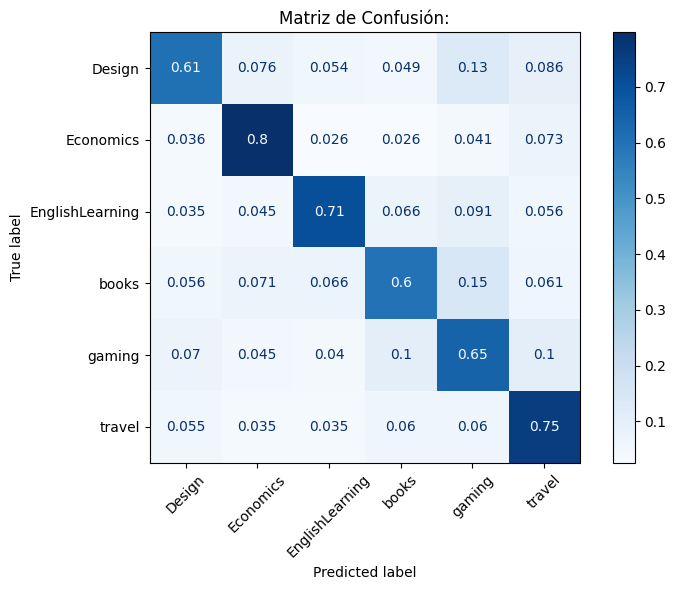

(RandomForestClassifier(n_estimators=200, random_state=2025),
 {'Design': {'precision': 0.691358024691358,
   'recall': 0.6054054054054054,
   'f1-score': 0.6455331412103746,
   'support': 185.0},
  'Economics': {'precision': 0.7439613526570048,
   'recall': 0.7979274611398963,
   'f1-score': 0.77,
   'support': 193.0},
  'EnglishLearning': {'precision': 0.7650273224043715,
   'recall': 0.7070707070707071,
   'f1-score': 0.7349081364829396,
   'support': 198.0},
  'books': {'precision': 0.6685393258426966,
   'recall': 0.601010101010101,
   'f1-score': 0.6329787234042553,
   'support': 198.0},
  'gaming': {'precision': 0.5863636363636363,
   'recall': 0.645,
   'f1-score': 0.6142857142857143,
   'support': 200.0},
  'travel': {'precision': 0.672645739910314,
   'recall': 0.7537688442211056,
   'f1-score': 0.7109004739336493,
   'support': 199.0},
  'accuracy': 0.6854219948849105,
  'macro avg': {'precision': 0.6879825669782303,
   'recall': 0.6850304198078693,
   'f1-score': 0.68476769

In [18]:
train_model_with_embeddings(
    df_comments,
    text_column ='processed_text',
    label_column ='subreddit',
    embedding_model = model_GLoVe_300, # Modelo GloVe cargado
    test_size = 0.2,
    random_state =2025,
    n_estimators =200,
    ngram_join_char ='_',
    handle_ngrams_strategy = None # 'average_components' o None
)

### **Análisis de Modelos basados en Word Embeddings**

#### Entrenamiento con Word Embeddings

#### Texto Procesado Manteniendo Stopwords
- **Capacidad Predictiva**: 0.6383.  
- **Observación**: Mantener las stopwords parece opacar la información clave ofrecida por los Word Embeddings de palabras más informativas. Esto ocurre porque los **Sentence Embeddings** de cada comentario se calculan promediando el Word Embedding de todos los tokens, incluyendo aquellos menos relevantes (stopwords).

#### Texto Procesado Eliminando Stopwords
- **Capacidad Predictiva**: 0.6854.  
- **Mejora Notable**: La eliminación de stopwords evita que estas ocluyan la información relevante y permite que el cálculo del **Sentence Embedding** se enfoque en los tokens más representativos. Sin embargo, aunque mejora respecto a mantener stopwords, sigue quedando rezagado frente a las representaciones tradicionales.

---

### Comparativa con Modelos Basados en Representación Tradicional
Los modelos basados en **representación tradicional** ofrecen una capacidad predictiva superior, especialmente aquellos entrenados con **BM25**, que ha demostrado ser más efectivo en este tipo de tareas.

#### Conclusión
- **Ventajas de Representaciones Tradicionales**: Estas parecen captar características más representativas y relevantes para esta tarea de clasificación de comentarios.
- **Limitaciones de Word Embeddings**: Aunque son útiles en tareas como modelado del lenguaje o generación de texto, no alcanzan el mismo desempeño en este contexto específico.

**BM25**, en particular, resalta como una representación más adecuada para tareas de clasificación, ofreciendo una capacidad predictiva que supera tanto a los Word Embeddings como a otras representaciones tradicionales.

# Fase 3: Modelado con Estrategia de Extracción de Características Alternativa (Uso de Unigramas, Bigramas y Trigramas)

En esta fase, exploraremos el impacto de utilizar una representación de texto más rica que incluya no solo palabras individuales (unigramas), sino también secuencias de dos palabras (bigramas) y tres palabras (trigramas). La hipótesis es que estos n-gramas pueden capturar mejor el contexto y frases hechas que son relevantes para distinguir entre subreddits pero habrá que comprobarlo con la comparación de la capacidad de los distintos modelos entrenados.

## 1. Representaciones Tradicionales (TF-IDF, BM25, etc.)

Para los modelos basados en representaciones tradicionales, la incorporación de bigramas y trigramas es relativamente directa utilizando `CountVectorizer` (o `TfidfVectorizer`) de scikit-learn. Simplemente ajustaremos el parámetro `ngram_range` a **(1, 3)** lo que generará un vocabulario que incluye unigramas, bigramas y trigramas. Estos se tratarán como características individuales en la matriz de términos.

## 2. Word Embeddings (GloVe)

Incorporar bigramas y trigramas con Word Embeddings (GloVe) requiere un enfoque diferente, ya que estos modelos de embedding suelen operar sobre "tokens" individuales predefinidos en su vocabulario. Nuestra estrategia para obtener el embedding global de un comentario, que sería una especie de **Sentence Embedding**, ya ha sido explicada en la parte donde construimos la función `train_model_with_embeddings`.

Esta estrategia nos permite derivar representaciones para n-gramas a partir de embeddings pre-entrenados de GloVe, incluso si el n-grama completo no está en su vocabulario, promediando los vectores de sus componentes (si están disponibles). El embedding promedio del comentario (**Sentence Embedding obtenido**), que combina unigramas y estas representaciones de n-gramas, se utiliza como características de entrada para el `RandomForestClassifier`.

**1) Modelos Representación Tradicional (Texto procesado con mantenimiento de stopwords + uso de bigramas y trigramas con CountVectorizer)**

Entrenando TF ...

Evaluando TF ...
Resultados TF  ----- Accuracy: 0.6287
                 precision    recall  f1-score   support

         Design       0.63      0.57      0.60       278
      Economics       0.58      0.79      0.67       290
EnglishLearning       0.73      0.71      0.72       300
          books       0.60      0.52      0.55       297
         gaming       0.63      0.53      0.57       300
         travel       0.61      0.66      0.64       299

       accuracy                           0.63      1764
      macro avg       0.63      0.63      0.63      1764
   weighted avg       0.63      0.63      0.63      1764



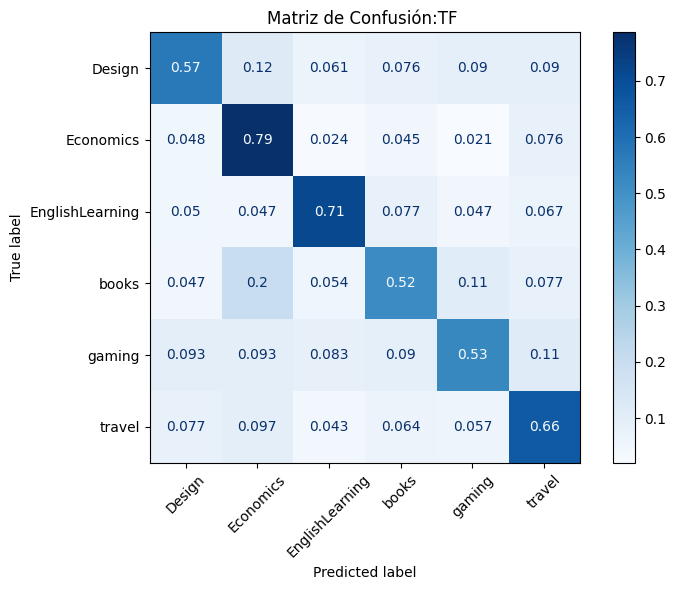

Entrenando TF-IDF ...

Evaluando TF-IDF ...
Resultados TF-IDF  ----- Accuracy: 0.7234
                 precision    recall  f1-score   support

         Design       0.86      0.50      0.63       278
      Economics       0.73      0.81      0.76       290
EnglishLearning       0.84      0.83      0.83       300
          books       0.61      0.71      0.66       297
         gaming       0.70      0.66      0.68       300
         travel       0.69      0.81      0.75       299

       accuracy                           0.72      1764
      macro avg       0.74      0.72      0.72      1764
   weighted avg       0.74      0.72      0.72      1764



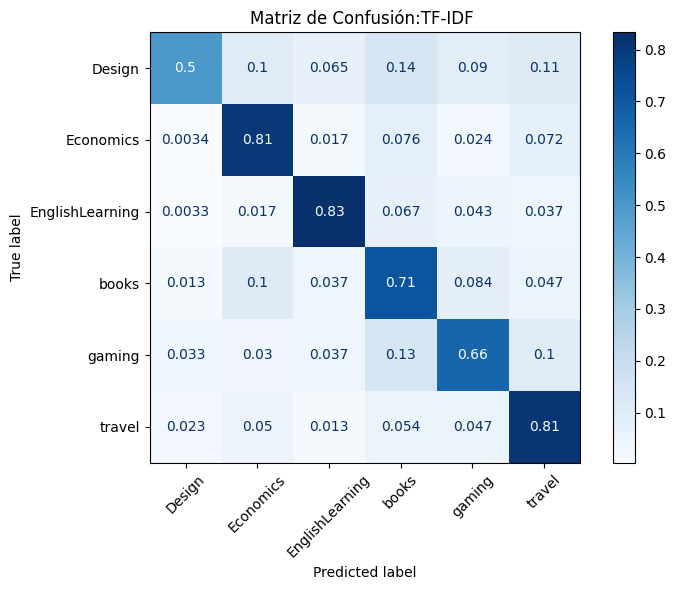

Entrenando BM25 ...

Evaluando BM25 ...
Resultados BM25  ----- Accuracy: 0.7364
                 precision    recall  f1-score   support

         Design       0.89      0.46      0.61       278
      Economics       0.83      0.76      0.79       290
EnglishLearning       0.83      0.85      0.84       300
          books       0.59      0.78      0.67       297
         gaming       0.73      0.69      0.71       300
         travel       0.70      0.86      0.77       299

       accuracy                           0.74      1764
      macro avg       0.76      0.73      0.73      1764
   weighted avg       0.76      0.74      0.73      1764



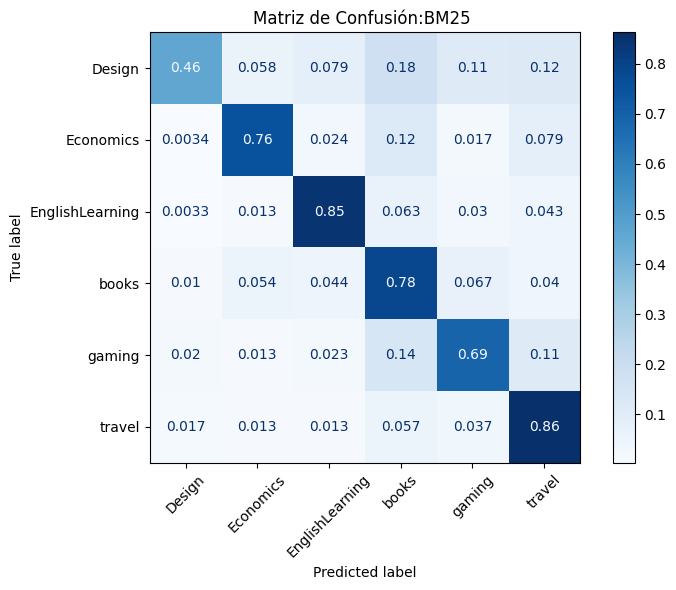

{'TF': Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 3))),
                 ('tf', TfidfTransformer(use_idf=False)),
                 ('clf', SVC(probability=True, random_state=2025, tol=1e-05))]),
 'TF-IDF': Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 3))),
                 ('tfidf', TfidfTransformer()),
                 ('clf',
                  SVC(C=2, degree=2, kernel='poly', probability=True,
                      random_state=2025, tol=0.0001))]),
 'BM25': Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 3))),
                 ('bm25', BM25Transformer(b=0.5)),
                 ('clf',
                  SVC(C=2, degree=2, kernel='poly', probability=True,
                      random_state=2025, tol=1e-05))])}

In [ ]:
train_evaluate_traditional_models(df_train['processed_text_with_stopwords'], df_train['subreddit'], df_test['processed_text_with_stopwords'], df_test['subreddit'],
                                      bm25_transformer_class=BM25Transformer,
                                      model_suffix="",
                                      cv_params= {'ngram_range': (1, 3)}  , # Parámetros para CountVectorizer, clave 'ngram_range' para trabajar con n-gramas
                                      tf_params_svc=None, # Parámetros para SVC en pipeline TF
                                      tfidf_params_svc=None, # Parámetros para SVC en pipeline TF-IDF
                                      bm25_params_svc=None, # Parámetros para SVC en pipeline BM25
                                      bm25_transformer_params=None # Parámetros para BM25Transformer
                                      )

**1) Modelos Representación Tradicional (Texto procesado con eliminación de stopwords + uso de bigramas y trigramas con CountVectorizer)**

Entrenando TF ...



Evaluando TF ...
Resultados TF  ----- Accuracy: 0.7381
                 precision    recall  f1-score   support

         Design       0.66      0.69      0.68       278
      Economics       0.80      0.80      0.80       290
EnglishLearning       0.79      0.74      0.76       300
          books       0.73      0.65      0.69       297
         gaming       0.71      0.73      0.72       300
         travel       0.75      0.82      0.78       299

       accuracy                           0.74      1764
      macro avg       0.74      0.74      0.74      1764
   weighted avg       0.74      0.74      0.74      1764



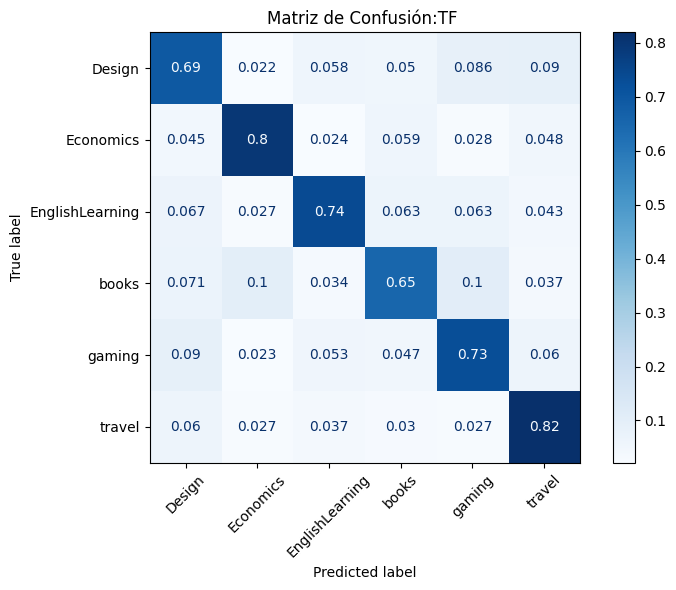

Entrenando TF-IDF ...

Evaluando TF-IDF ...
Resultados TF-IDF  ----- Accuracy: 0.7795
                 precision    recall  f1-score   support

         Design       0.81      0.67      0.73       278
      Economics       0.88      0.78      0.83       290
EnglishLearning       0.81      0.83      0.82       300
          books       0.71      0.78      0.74       297
         gaming       0.76      0.75      0.75       300
         travel       0.74      0.87      0.80       299

       accuracy                           0.78      1764
      macro avg       0.78      0.78      0.78      1764
   weighted avg       0.78      0.78      0.78      1764



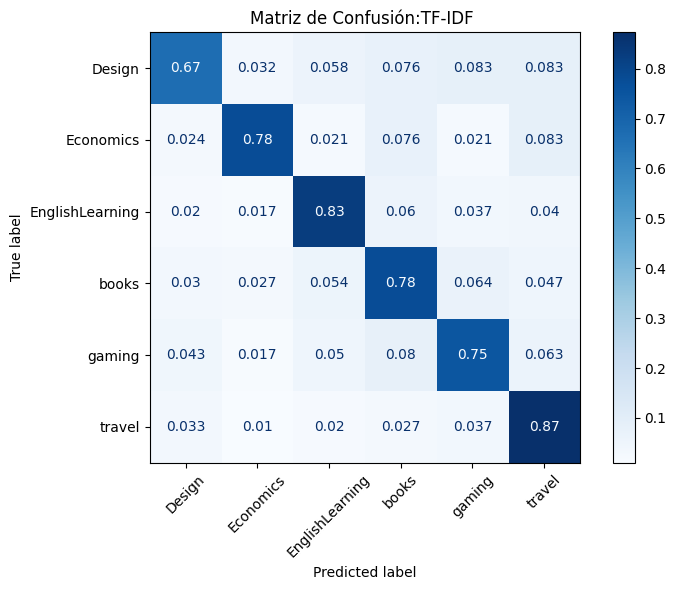

Entrenando BM25 ...

Evaluando BM25 ...
Resultados BM25  ----- Accuracy: 0.7744
                 precision    recall  f1-score   support

         Design       0.82      0.64      0.72       278
      Economics       0.90      0.75      0.82       290
EnglishLearning       0.79      0.84      0.81       300
          books       0.71      0.78      0.74       297
         gaming       0.76      0.75      0.76       300
         travel       0.73      0.87      0.79       299

       accuracy                           0.77      1764
      macro avg       0.78      0.77      0.77      1764
   weighted avg       0.78      0.77      0.77      1764



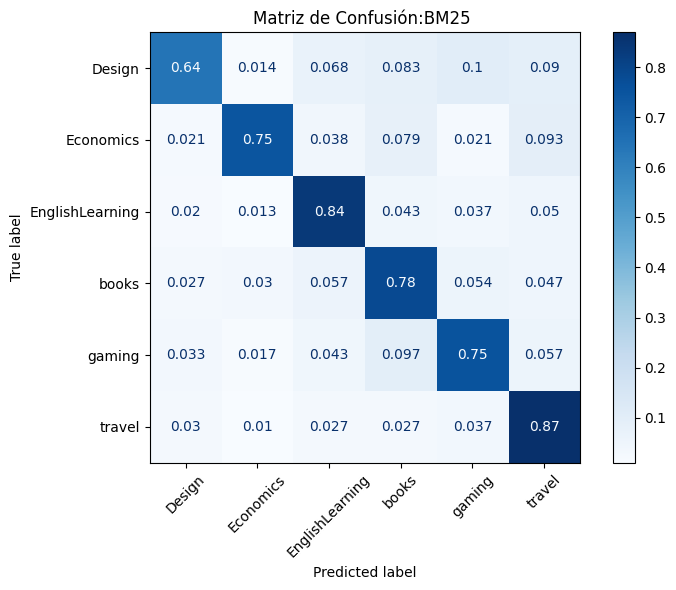

{'TF': Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 3))),
                 ('tf', TfidfTransformer(use_idf=False)),
                 ('clf', SVC(probability=True, random_state=2025, tol=1e-05))]),
 'TF-IDF': Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 3))),
                 ('tfidf', TfidfTransformer()),
                 ('clf',
                  SVC(C=2, degree=2, kernel='poly', probability=True,
                      random_state=2025, tol=0.0001))]),
 'BM25': Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 3))),
                 ('bm25', BM25Transformer(b=0.5)),
                 ('clf',
                  SVC(C=2, degree=2, kernel='poly', probability=True,
                      random_state=2025, tol=1e-05))])}

In [ ]:
train_evaluate_traditional_models(df_train['processed_text'], df_train['subreddit'], df_test['processed_text'], df_test['subreddit'],
                                      bm25_transformer_class=BM25Transformer,
                                      model_suffix="",
                                      cv_params= {'ngram_range': (1, 3)}  , # Parámetros para CountVectorizer, clave 'ngram_range' para trabajar con n-gramas
                                      tf_params_svc=None, # Parámetros para SVC en pipeline TF
                                      tfidf_params_svc=None, # Parámetros para SVC en pipeline TF-IDF
                                      bm25_params_svc=None, # Parámetros para SVC en pipeline BM25
                                      bm25_transformer_params=None # Parámetros para BM25Transformer
                                      )

**2) Modelo con Word Embeddings (Texto Procesado con Mantenimiento de Stopwords)**

Decidimos no entrenar el modelo con word embeddings generados a partir de texto que mantiene las stopwords. Esta decisión se basa en observaciones previas que muestran una reducción considerable en la capacidad discriminatoria del modelo bajo estas condiciones.

La principal hipótesis de este comportamiento es que, al promediar los embeddings de todos los tokens para generar el **Sentence Embedding**, las stopwords, que no aportan información significativa, diluyen el peso de los tokens más informativos. Esto provoca que las características clave, esenciales para distinguir entre subreddits, queden opacadas por la presencia de tokens irrelevantes. Como resultado, el modelo pierde precisión al identificar patrones específicos en los comentarios.

Resultados ----- Accuracy: 0.6811
Entrenamiento completado


Reporte de clasificación:
                 precision    recall  f1-score   support

         Design       0.70      0.63      0.67       185
      Economics       0.73      0.80      0.76       193
EnglishLearning       0.78      0.75      0.76       200
          books       0.61      0.56      0.58       198
         gaming       0.61      0.63      0.62       200
         travel       0.67      0.71      0.69       200

       accuracy                           0.68      1176
      macro avg       0.68      0.68      0.68      1176
   weighted avg       0.68      0.68      0.68      1176



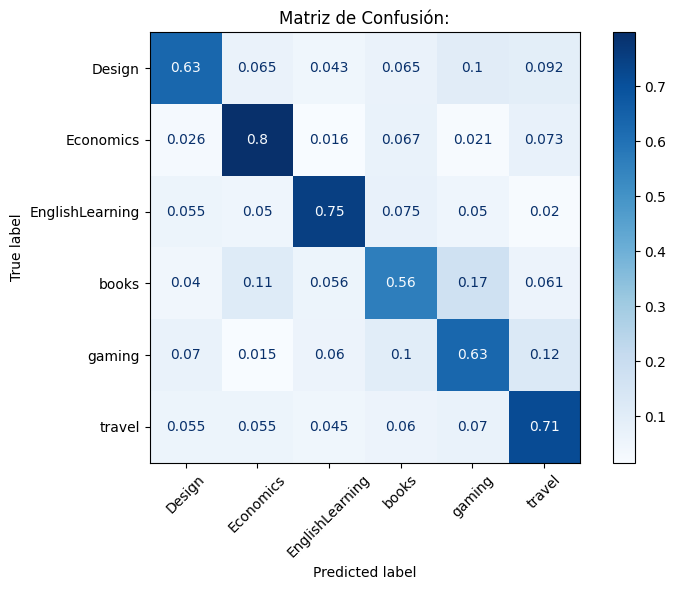

(RandomForestClassifier(n_estimators=200, random_state=2025),
 {'Design': {'precision': 0.7048192771084337,
   'recall': 0.6324324324324324,
   'f1-score': 0.6666666666666666,
   'support': 185.0},
  'Economics': {'precision': 0.7264150943396226,
   'recall': 0.7979274611398963,
   'f1-score': 0.7604938271604939,
   'support': 193.0},
  'EnglishLearning': {'precision': 0.7772020725388601,
   'recall': 0.75,
   'f1-score': 0.7633587786259542,
   'support': 200.0},
  'books': {'precision': 0.6065573770491803,
   'recall': 0.5606060606060606,
   'f1-score': 0.5826771653543307,
   'support': 198.0},
  'gaming': {'precision': 0.6086956521739131,
   'recall': 0.63,
   'f1-score': 0.6191646191646192,
   'support': 200.0},
  'travel': {'precision': 0.6651162790697674,
   'recall': 0.715,
   'f1-score': 0.689156626506024,
   'support': 200.0},
  'accuracy': 0.6811224489795918,
  'macro avg': {'precision': 0.6814676253799629,
   'recall': 0.6809943256963983,
   'f1-score': 0.680252947246348,
   

In [ ]:
train_model_with_embeddings(
    df_comments,
    text_column ='processed_text',
    label_column ='subreddit',
    embedding_model = model_GLoVe_300, # Modelo GloVe cargado
    embedding_dim=300, # Necesario si el modelo no puede proveerlo o para ceros
    test_size = 0.2,
    random_state =2025,
    n_estimators =200,
    ngram_join_char ='_',
    handle_ngrams_strategy = 'average_components' # 'average_components' o None
)

#### **Análisis del Rendimiento Usando N-gramas**

Tras observar el rendimiento de los modelos al incorporar **n-gramas** (unigramas, bigramas y trigramas), notamos que no se logra una mejora sustancial en su desempeño. Esto sugiere que, para esta tarea específica, los **unigramas** son lo suficientemente informativos para clasificar los comentarios en su subreddit correspondiente.

La incorporación de bigramas y trigramas puede incluso resultar contraproducente, ya que parece opacar la información clave contenida en los unigramas. En algunos casos, este fenómeno lleva a una **reducción en la capacidad clasificatoria** de ciertos modelos.

Esta observación refuerza la idea de que, en tareas donde las palabras individuales aportan información relevante, los unigramas son una representación más eficiente que los n-gramas de mayor tamaño, esto se puede percibir, sobre todo, en los modelos basados en **Word Embeddings**. 

# Transformers (Fine-tuning) con Texto No Procesado

Ahora vamos a introducir un nuevo enfoque para clasificar estos comentarios en sus respectivos subreddits, la idea es realizar un **Fine-Tuning** a un LLM preentrenado para que este sea capaz de clasificar los comentarios correctamente a partir del uso del **texto original (no procesado)** de los comentarios.

Hemos escogido de `Hugging Face` el siguiente modelo y tokenizador: `DistilBertForSequenceClassification` y `DistilBertTokenizer`.

## ¿Por qué Texto No Procesado?

1.  **Coherencia con el Preentrenamiento Masivo:**
    *   Los Transformers se preentrenan en enormes corpus de texto con su propio sistema de tokenización. Nuestro preprocesamiento personalizado (lematización, eliminación de stopwords) alteraría drásticamente la entrada, creando una discrepancia con lo que el modelo aprendió.

2.  **Tokenizadores Específicos del Modelo:**
    *   Cada Transformer usa un tokenizador especializado, en nuestro caso es `DistilBertTokenizer` ,que maneja texto crudo mediante subpalabras. Este tokenizador es el encargado de preparar el texto para el modelo.

3.  **Aprendizaje Durante el Fine-tuning:**
    *   Durante el fine-tuning, el modelo aprende qué partes del texto de entrada (incluyendo stopwords o formas flexionadas) son importantes para la tarea específica de clasificar los comentarios en subreddits. No necesitamos eliminar esta información de antemano.



**Lo que hicimos, en resumen:**

1.  **Preparamos los Datos:** Cargamos comentarios y etiquetas, los limpiamos y creamos mapeos numéricos para las etiquetas.
2.  **Tokenizamos:** Usamos el tokenizador de `DistilBert` para convertir el texto al formato que el modelo necesita.
3.  **Configuramos el Modelo:** Cargamos `DistilBertForSequenceClassification` pre-entrenado y lo adaptamos a nuestro número de etiquetas.
4.  **Entrenamos:** Definimos los parámetros de entrenamiento (épocas, tasa de aprendizaje, etc.) y usamos la clase `Trainer` de Hugging Face para realizar el fine-tuning. Evaluamos métricas como accuracy y F1 en cada época.
5.  **Guardamos y Analizamos:** Guardamos el modelo afinado, el tokenizador y los mapeos. También generamos una matriz de confusión para ver el rendimiento de este LLM tuneado.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/4704 [00:00<?, ? examples/s]

Map:   0%|          | 0/1176 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-4-c7191c403596>:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gcid20339 (gcid20339-upct-universidad-polit-cnica-de-cartagena) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.772900,1.749292,0.352041,0.443414,0.352041,0.299419
2,1.270000,1.246501,0.662415,0.680616,0.662415,0.643928
3,0.883300,0.833636,0.745748,0.746524,0.745748,0.742252
4,0.624900,0.676047,0.781463,0.786916,0.781463,0.782313
5,0.458600,0.622390,0.805272,0.806252,0.805272,0.804745
6,0.382700,0.618554,0.801020,0.802794,0.801020,0.801129
7,0.260700,0.617387,0.811224,0.810790,0.811224,0.810845



Evaluación en el conjunto de prueba:


{'eval_loss': 0.6173874735832214, 'eval_accuracy': 0.8112244897959183, 'eval_precision': 0.8107897919616499, 'eval_recall': 0.8112244897959183, 'eval_f1': 0.8108445791454165, 'eval_runtime': 0.4321, 'eval_samples_per_second': 2721.762, 'eval_steps_per_second': 85.634, 'epoch': 7.0}
Entrenamiento completado y modelo guardado.


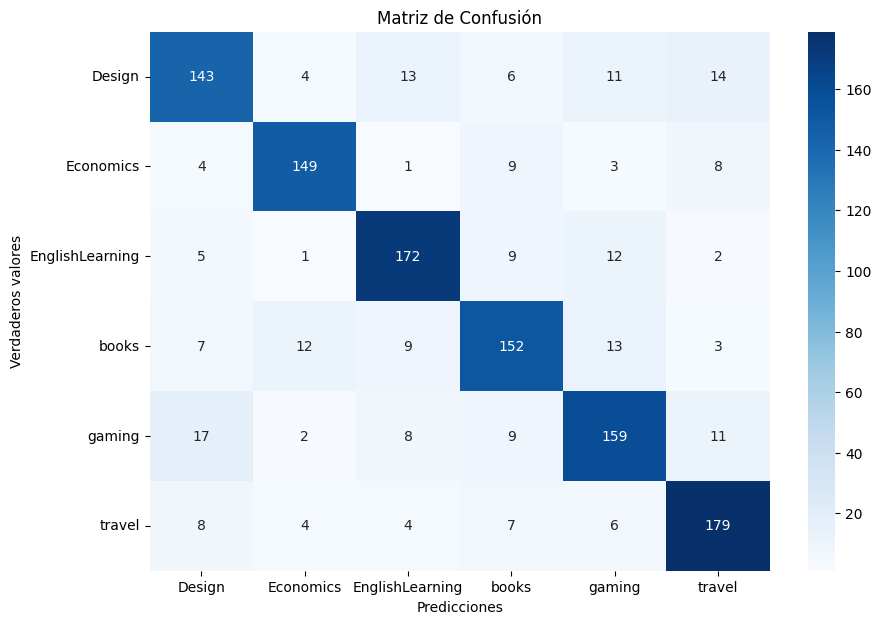

In [ ]:
def train_model(file_path, text_column='body', batch_size=32, num_epochs=3, learning_rate=1e-5, max_length=128):
    # Cargar los datos
    data = pd.read_csv(file_path)

    # Preprocesamiento de datos
    data = data.dropna(subset=[text_column, 'subreddit'])
    texts = data[text_column].astype(str).tolist()
    labels = data['subreddit'].tolist()

    # Mapeo de etiquetas
    label2id = {label: idx for idx, label in enumerate(sorted(set(labels)))}
    id2label = {idx: label for label, idx in label2id.items()}

    # Crear dataset
    df = pd.DataFrame({'text': texts, 'label': [label2id[label] for label in labels]})
    df = df[df['text'].str.strip().astype(bool)]
    dataset = Dataset.from_pandas(df).train_test_split(test_size=0.2, seed=42)

    # Tokenización
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    def tokenize_function(examples):
        return tokenizer(examples['text'], truncation=True, max_length=max_length)

    tokenized_datasets = dataset.map(tokenize_function, batched=True)

    # Modelo
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )

    # Configuración de entrenamiento
    training_args = TrainingArguments(
        output_dir='./results',
        eval_strategy='epoch',
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        warmup_steps=600,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        save_strategy='epoch',
        load_best_model_at_end=True,
        fp16=True if torch.cuda.is_available() else False
    )

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Definir el evaluador personalizado
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(axis=-1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "precision": precision_score(labels, preds, average='weighted', zero_division=0),
            "recall": recall_score(labels, preds, average='weighted', zero_division=0),
            "f1": f1_score(labels, preds, average='weighted', zero_division=0),
        }

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['test'],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # Entrenamiento
    trainer.train()

    # Evaluación final
    print("\nEvaluación en el conjunto de prueba:")
    metrics = trainer.evaluate()
    print(metrics)

    # Guardar modelo
    model.save_pretrained('./reddit-topic-classifier')
    tokenizer.save_pretrained('./reddit-topic-classifier')

    # Guardar mapeos
    with open('./reddit-topic-classifier/label_mappings.json', 'w') as f:
        json.dump({'label2id': label2id, 'id2label': id2label}, f)
    print("Entrenamiento completado y modelo guardado.")



    # Generar las predicciones del conjunto de prueba
    predictions = trainer.predict(tokenized_datasets['test'])
    preds = predictions.predictions.argmax(axis=-1)
    labels = predictions.label_ids

    # Crear la matriz de confusión
    conf_matrix = confusion_matrix(labels, preds)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label2id.keys(), yticklabels=label2id.keys())
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicciones')
    plt.ylabel('Verdaderos valores')
    plt.show()
    return model, metrics, trainer




# Entrenamiento, inferencia y evaluación del modelo
trained_model, test_metrics, trainer = train_model(
    'sample_data/comments_data_3.0.csv',
    text_column='body',
    batch_size=32,
    num_epochs=7,
    learning_rate=1e-5
)

API Key WanDB.ai: 367d9a23eea4f2273d580c85072d252f261cf470

### **Fine-Tuning de DistilBERT vs Representación Tradicional BM25**


#### Resultados Obtenidos

Tras el fine-tuning, el modelo **DistilBERT** alcanzó una capacidad predictiva con una precisión de **0.8112**, lo cual es muy similar al mejor rendimiento observado con **BM25** entrenado sobre texto procesado **manteniendo stopwords**.

#### Observaciones
1. **Cota Superior de Capacidad Predictiva**: Estos resultados sugieren que, aproximadamente, **0.82** podría ser una cota superior para la capacidad máxima alcanzable en este dataset. Esto se debe a la naturaleza de los subreddits, algunos de los cuales presentan un solapamiento significativo de contenido, dificultando la clasificación.

2. **Costos de Fine-Tuning**: 
   - El proceso de fine-tuning en un modelo LLM como DistilBERT conlleva un **alto costo computacional**, lo que lo hace menos eficiente en términos de recursos y tiempo.

3. **Comparativa con BM25**:
   - BM25, en su configuración óptima (texto procesado, manteniendo stopwords), logra un rendimiento muy similar al fine-tuned DistilBERT.
   - En términos de eficiencia, **BM25 es mucho más económico y práctico** para este tipo de tareas, ya que no requiere un entrenamiento tan intensivo.

### Conclusión

Aunque el fine-tuning de DistilBERT nos permitió explorar los límites superiores de capacidad predictiva en este dataset, los resultados indican que **BM25** es una alternativa más eficiente y viable para tareas de clasificación donde el rendimiento es comparable.



# 3) Búsqueda de hilos similares

In [ ]:
# Descargamos Fasttext con formato binario para utilizarse con la librería Fasttext 
!wget -c --no-check-certificate https://valencia.inf.um.es/valencia-plne/embeddings-s-model.bin.gz
!gzip -d embeddings-s-model.bin.gz

In [ ]:
import fasttext # fasttext está basado en la construcción de embeddings mediante char-n-gramas

### Debemos encontrar los hilos más parecidos entre sí, basándonos en la información que aportan todos los comentarios de cada hilo.

In [ ]:
# Agrupamos los comentarios por hilo y concatenamos el texto
grouped = df_comments.groupby("thread_title")["processed_text"].apply(
    lambda texts: " ".join(str(t).replace("\n", " ") for t in texts if pd.notnull(t))
)

# Extraemos los títulos de hilo y el texto completo
thread_titles = grouped.index.tolist()
thread_texts = grouped.tolist()

# Obtenemos el subreddit al que pertenece cada hilo
thread_subreddits = df_comments.groupby("thread_title")["subreddit"].first().tolist()

In [ ]:
hilos_df = pd.DataFrame({
    "thread_title": thread_titles,
    "thread_text": thread_texts,
    "subreddit": thread_subreddits
})

hilos_df.head(5)

In [ ]:
ft_model = fasttext.load_model("embeddings-s-model.bin")
hilos_df["embedding"] = hilos_df["thread_text"].apply(lambda x: ft_model.get_sentence_vector(x))
embedding_matrix = np.vstack(hilos_df["embedding"].values)


#Reducción de dimensionalidad mediante PCA y t-SNE:
pca = PCA(n_components=embedding_matrix.shape[1])
reduc = pca.fit_transform(embedding_matrix)

tsne = TSNE(n_components=2, init="pca", perplexity=30, max_iter=1000, random_state=42)
coords = tsne.fit_transform(reduc)


# Plot: cada punto es un hilo, coloreado por subreddit
vis_df = pd.DataFrame(coords, columns=["dim1","dim2"])
vis_df["subreddit"] = hilos_df["subreddit"]

plt.figure(figsize=(10,8))
sns.scatterplot(
    data=vis_df, x="dim1", y="dim2",
    hue="subreddit", palette="tab10",
    s=50, alpha=0.7
)
for i, (x, y) in enumerate(zip(vis_df["dim1"], vis_df["dim2"])):
    plt.annotate(
        str(i),
        xy=(x, y),
        xytext=(5, 0),            # desplaza 5 puntos hacia la derecha
        textcoords="offset points",
        fontsize=6,
        ha="left",
        va="center"
    )

### Si quisiesemos ver la información de un hilo en específico podemos realizar:

In [ ]:
hilos_df.iloc[0]

A continuación, se presenta un análisis comparativo de diferentes modelos de sentence-transformers utilizados para la tarea de búsqueda de hilos similares. 

Los modelos seleccionados para esta evaluación son:

*   **all-MiniLM-L6-v2:**
    *   **Descripción:** Este modelo destaca por su ligereza y rapidez de evaluación, lo que lo convierte en una opción eficiente para tareas que requieren un procesamiento rápido.
    *   **Idioma:** Inglés puro.
    *   **Consideraciones:** Debido a su tamaño reducido, puede que no capture todos los matices semánticos presentes en el texto.

*   **all-mpnet-base-v2:**
    *   **Descripción:** Este modelo ofrece un alto nivel de detalle semántico y una gran precisión, lo que lo hace adecuado para tareas que demandan una comprensión profunda del significado del texto.
    *   **Idioma:** Inglés puro.
    *   **Consideraciones:** Su mayor complejidad puede resultar en tiempos de evaluación más largos en comparación con modelos más ligeros.

*   **paraphrase-multilingual-mpnet-base-v2:**
    *   **Descripción:** Este modelo se caracteriza por su exhaustividad y su capacidad para manejar múltiples idiomas, lo que lo convierte en una opción versátil para proyectos multilingües.
    *   **Idioma:** Multilingüe.
    *   **Consideraciones:** Aunque es multilingüe, su rendimiento puede variar dependiendo del idioma del texto de entrada. Es importante evaluar su desempeño en el idioma específico del proyecto.



In [ ]:
from sentence_transformers import SentenceTransformer

# Definimos los modelos a comparar
model_specs = {
    "MiniLM-L6-v2":         "sentence-transformers/all-MiniLM-L6-v2",
    "MPNet-base-v2":        "sentence-transformers/all-mpnet-base-v2",
    "MPNet-multilingual":   "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
}

results = []
texts = hilos_df["thread_text"].tolist()
subs  = hilos_df["subreddit"].values

# Evaluar cada modelo
for name, model_name in model_specs.items():
    print(f"Cargando modelo: {name} …")
    model = SentenceTransformer(model_name)

    # Codificar textos
    embeddings = model.encode(
        texts,
        batch_size=32,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True  # Mejora la comparación con cosine_similarity
    )

    # Calcular similitudes
    sim_matrix = cosine_similarity(embeddings)

    intra = []
    inter = []
    n = len(subs)
    for i in range(n):
        for j in range(i + 1, n):
            if subs[i] == subs[j]:
                intra.append(sim_matrix[i, j])
            else:
                inter.append(sim_matrix[i, j])

    # resultados
    results.append({
        "model": name,
        "avg_intra_similarity": np.mean(intra) if intra else 0,
        "avg_inter_similarity": np.mean(inter) if inter else 0,
        "difference": (np.mean(intra) - np.mean(inter)) if intra and inter else 0
    })

# Mostrar resultados
res_df = pd.DataFrame(results).set_index("model")
print("\nComparativa de modelos:")
res_df.round(4)

**Comparativa de modelos de Sentence Transformers**

El objetivo es analizar la capacidad de tres modelos de Sentence Transformers para identificar la similitud entre hilos de Reddit, diferenciando aquellos dentro del mismo subreddit (intra-subreddit) de aquellos en diferentes subreddits (inter-subreddit).

**Modelos Evaluados:**

*   **MiniLM-L6-v2:** Modelo ligero y rápido.
*   **MPNet-base-v2:** Modelo con alto detalle semántico y precisión.
*   **MPNet-multilingual:** Modelo versátil, capaz de manejar múltiples idiomas.

**Métricas Clave:**

*   **avg\_intra\_similarity:** Similitud promedio entre hilos dentro del mismo subreddit.
*   **avg\_inter\_similarity:** Similitud promedio entre hilos de diferentes subreddits.
*   **difference:** Diferencia entre la similitud intra-subreddit y la similitud inter-subreddit. Una mayor diferencia indica una mejor capacidad para discriminar entre hilos del mismo y diferentes subreddits.

**Resultados:**

| Model              | avg\_intra\_similarity | avg\_inter\_similarity | difference |
| :----------------- | :--------------------- | :--------------------- | :--------- |
| MiniLM-L6-v2       | 0.4332                 | 0.3142                 | 0.1190     |
| MPNet-base-v2      | 0.6511                 | 0.5256                 | 0.1255     |
| MPNet-multilingual | 0.5166                 | 0.3665                 | 0.1501     |

**Análisis Comparativo:**

*   **MPNet-base-v2:** Exhibe la mayor similitud tanto dentro del mismo subreddit (0.6511) como entre diferentes subreddits (0.5256). Esto sugiere que este modelo captura de manera más efectiva la semántica general del texto. Sin embargo, su alta similitud inter-subreddit indica que podría ser menos específico al distinguir entre temas de diferentes comunidades.

*   **MiniLM-L6-v2:** Muestra la menor similitud intra-subreddit (0.4332) e inter-subreddit (0.3142). Esto indica una menor capacidad para capturar la semántica subyacente, aunque también podría interpretarse como una mayor especificidad al identificar hilos temáticamente similares.

*   **MPNet-multilingual:** Presenta una similitud intra-subreddit (0.5166) y una similitud inter-subreddit (0.3665) en un punto intermedio. Notablemente, este modelo tiene la mayor diferencia entre ambas métricas (0.1501). Esto sugiere que es el más efectivo para discriminar entre hilos que pertenecen al mismo subreddit y aquellos que son de diferentes subreddits.

**Conclusión:**

La selección del modelo óptimo depende del objetivo del análisis.

*   Si la prioridad es capturar la semántica general del texto con la mayor precisión posible, **MPNet-base-v2** es la opción preferible.
*   Si el enfoque principal es la discriminación entre hilos de diferentes subreddits, **MPNet-multilingual** demuestra ser el más adecuado.
*   **MiniLM-L6-v2** podría ser considerado en escenarios donde la velocidad y la eficiencia son críticas, aunque a expensas de la precisión semántica.


# 4) Análisis de subjetividad de los comentarios

En este apartado, llevamos a cabo un análisis exhaustivo de los comentarios para identificar tanto el sentimiento general como las emociones predominantes mediante modelos preentrenados para esta tarea. El proceso incluye la preparación de los datos, la inferencia con los modelos y el almacenamiento de los resultados en JSON.

## Modelos Utilizados

1. **Análisis de Sentimientos**:
   - Modelo: `pysentimiento/robertuito-sentiment-analysis`
   - Etiquetas:
     - **POS** (positivo)
     - **NEU** (neutral)
     - **NEG** (negativo)
   - Este modelo clasifica el tono general de cada comentario y nos permite identificar su polaridad.

2. **Análisis de Emociones**:
   - Modelo: `finiteautomata/beto-emotion-analysis`
   - Etiquetas:
     - **joy** (alegría)
     - **sadness** (tristeza)
     - **anger** (enojo)
     - **fear** (miedo)
     - **surprise** (sorpresa)
     - **disgust** (asco)
     - **others** (otros; comentarios que no encajan en emociones principales)
   - Este modelo nos proporciona una visión más detallada de las emociones presentes en los comentarios.



## Proceso de Análisis

1. **Preprocesamiento de los Datos**:
   - Se eliminan las filas con valores `NaN` en los comentarios (`body`), por si en el procesamiento de apartados anteriores se ha colado alguno, y se convierten los textos a tipo `string`.
   - Los datos se convierten en un `Dataset` de Hugging Face para ser procesados en lotes.

2. **Inferencia con los Modelos**:
   - **Análisis de Sentimientos**: Para cada comentario, se obtienen las probabilidades de las tres etiquetas (`POS`, `NEU`, `NEG`) utilizando el parámetro `top_k=3`.
   - **Análisis de Emociones**: De manera similar, se obtienen las probabilidades de las seis etiquetas emocionales y la etiqueta `others`, con `top_k=6`.

3. **Asignación de Resultados**:
   - Se asigna la etiqueta con mayor puntuación como la clasificación principal de cada comentario.
   - Además, se guarda la lista completa de probabilidades (`{label: score}`) para cada modelo, lo que permite un análisis posterior más detallado.

## Guardado de Resultados

El DataFrame procesado se guarda en un archivo JSON, `comments_with_full_sentiment_emotion_scores.json`, con las siguientes columnas adicionales:
- **`sentiment`**: La etiqueta principal del análisis de sentimiento.
- **`sentiment_all_scores`**: Lista de probabilidades para las etiquetas de sentimiento.
- **`emotion`**: La etiqueta principal del análisis de emociones.
- **`emotion_all_scores`**: Lista de probabilidades para las etiquetas de emociones.


In [ ]:
import torch
from transformers import pipeline
from datasets import Dataset
import pandas as pd
from tqdm import tqdm
import json

# Verificar si hay GPU disponible y configurar el dispositivo
device = 0 if torch.cuda.is_available() else -1

# Cargar los modelos de análisis de sentimientos y emociones
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="pysentimiento/robertuito-sentiment-analysis",
    tokenizer="pysentimiento/robertuito-sentiment-analysis",
    device=device,
    batch_size=8, # Ajusta según la VRAM de tu GPU
    truncation=True
)

emotion_pipeline = pipeline(
    "text-classification",
    model="finiteautomata/beto-emotion-analysis",
    tokenizer="finiteautomata/beto-emotion-analysis",
    device=device,
    batch_size=8, # Ajusta según la VRAM de tu GPU
    truncation=True
)


# Preprocesamiento básico: eliminar filas donde 'body' es NaN y convertir a string
df_comments_processed = df_comments.dropna(subset=['body']).copy()
df_comments_processed['body'] = df_comments_processed['body'].astype(str)



# Convertir la columna de texto a un Dataset de Hugging Face
dataset = Dataset.from_pandas(df_comments_processed[['body']])


# Aplicar los modelos en lotes, solicitando todos los scores/probabilidades:

# El modelo de sentimiento pysentimiento tiene 3 etiquetas, por eso top_k=3
print("Analizando sentimientos...")
sentiment_results_full = []
for out in tqdm(sentiment_pipeline(dataset['body'], top_k=3, truncation=True), total=len(dataset)):
    sentiment_results_full.append(out)

# El modelo de emoción beto-emotion-analysis tiene 6 etiquetas, por eso top_k=6
print("Analizando emociones...")
emotion_results_full = []
for out in tqdm(emotion_pipeline(dataset['body'], top_k=6, truncation=True), total=len(dataset)):
    emotion_results_full.append(out)


# Asignar los resultados al DataFrame
# La etiqueta principal será la primera de la lista (la que tiene mayor score).
df_comments_processed['sentiment'] = [res_list[0]['label'] for res_list in sentiment_results_full]
# Guardar la lista completa de {label: score} para sentimientos
df_comments_processed['sentiment_all_scores'] = sentiment_results_full

df_comments_processed['emotion'] = [res_list[0]['label'] for res_list in emotion_results_full]
# Guardar la lista completa de {label: score} para emociones
df_comments_processed['emotion_all_scores'] = emotion_results_full


# Guardar los resultados en un archivo JSON
# Se utiliza df_comments_processed que es la copia con las filas NaN eliminadas y las nuevas columnas.
output_file = "comments_with_full_sentiment_emotion_scores.json"
df_comments_processed.to_json(output_file, orient="records", lines=True, force_ascii=False, indent=4)

print(f"\nAnálisis completado. Archivo guardado en: {output_file}")

# Muestra de una fila del DataFrame resultante
if not df_comments_processed.empty:
    print("\nMuestra de una fila del DataFrame procesado:")
    sample_row = df_comments_processed.sample(1).iloc[0].to_dict() # Tomar una muestra aleatoria
    # Imprimir de forma legible
    for key, value in sample_row.items():
        if key in ['sentiment_all_scores', 'emotion_all_scores']:
            print(f"  {key}:")
            for item in value:
                print(f"    - {item}")
        else:
            print(f"  {key}: {value}")
else:
    print("El DataFrame procesado está vacío.")


Device set to use cuda:0
Device set to use cuda:0


Analizando sentimientos...


100%|██████████| 5880/5880 [00:00<00:00, 2629545.53it/s]


Analizando emociones...


100%|██████████| 5880/5880 [00:00<00:00, 2507371.65it/s]



Análisis completado. Archivo guardado en: comments_with_full_sentiment_emotion_scores.json

Muestra de una fila del DataFrame procesado:
  body: I was there 2 years ago. Found our car rental service on instagram lol, but we were staisfied and the price was good also  @ makina.me.qera.tirana
  score: 1
  created_utc: 2025-04-24T07:43:58
  thread_title: Four days in Tirana, Albania in April 2025
  subreddit: travel
  processed_text: year ago find car rental service instagram low satisfied price good makina.me.qera.tirana
  processed_text_with_stopwords: I be there year ago find our car rental service on instagram low but we be satisfied and the price be good also a makina.me.qera.tirana
  sentiment: POS
  sentiment_all_scores:
    - {'label': 'POS', 'score': 0.7836300730705261}
    - {'label': 'NEU', 'score': 0.1951136440038681}
    - {'label': 'NEG', 'score': 0.02125627174973488}
  emotion: others
  emotion_all_scores:
    - {'label': 'others', 'score': 0.9184492230415344}
    - {'labe

### Ejemplo de Análisis de Subjetividad

Este ejemplo muestra cómo se procesan los comentarios para análisis de sentimientos y emociones:

- **Texto original (`body`)**: Comentario en inglés sobre un servicio de alquiler donde el cliente queda satisfecho.
- **Sentimiento (`sentiment`)**: `POS` (positivo), con una probabilidad del 78.36%.
- **Emoción (`emotion`)**: `others` (sin emoción predominante), con una probabilidad del 91.84%.

También se incluyen las probabilidades detalladas para todas las etiquetas, tanto de sentimiento como de emociones. Esto permite un análisis granular del tono y las emociones presentes en el comentario.

Como comentario final decir que el modelo entrenado para análisis de sentimiento tiene un rendimiento bastante bueno a la hora de identificar esa positividad, negatividad o neutralidad en los comentarios, suele acertar el sentimiento asociado al comentario en la mayoría de ocasiones. Sin embargo, el modelo de BETO entrenado para análisis de emociones encuentra dificultades, en varias ocasiones, para identificar la emoción específica del comentario, sobre todo cuando es de un tono neutral. Aunque es cierto que, a veces, es también difícil para el humano distinguir la emoción que hay detrás del comentario de otra persona, por lo tanto, digamos que tiene un funcionamiento parecido al que tendría un humano.

# 5) Resumen automático abstractivo

### 5.1) Uso de `mT5_multilingual_XLSum` para realizar la tarea de resumen abstractivo

In [ ]:
from huggingface_hub import login

login(token="hf_XXXXXXXX")

#### Para obtener la metodología adecuada para aplicar el modelo, nos hemos basado en la respectiva documentación de [hugging_face](https://huggingface.co/csebuetnlp/mT5_multilingual_XLSum).

In [ ]:
import warnings
# silenciamos warnings que indican información extra acerca de los transformers que no interesa

warnings.filterwarnings("ignore", message=".*byte fallback option.*")

# Función para limpiar saltos de línea y espacios redundantes
WHITESPACE_HANDLER = lambda k: re.sub(r'\s+', ' ',
                                     re.sub(r'\n+', ' ', k.strip()))

# Agrupamos los comentarios por hilo y concatenamos el texto
grouped = df_comments.groupby("thread_title")["processed_text"].apply(list)

# Cargamos el modelo y tokenizador de mT5_multilingual_XLSum
model_name = "csebuetnlp/mT5_multilingual_XLSum"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda")


# Función que genera el resumen para cada hilo
def summarize_thread(title, comments,
                     max_input_length=1024,
                     max_summary_length=150):
    # Filtra y convertierte todo a cadena
    clean_comments = [str(c) for c in comments if pd.notnull(c)]
    # Construir el texto de entrada
    text    = f"{title}." + " ".join(clean_comments)
    # Limpia y trunca
    cleaned = WHITESPACE_HANDLER(text)[:max_input_length]
    inputs  = tokenizer(
        cleaned,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_input_length
    )

    # Generación de la salida (summary)
    output_ids = model.generate(
        input_ids=inputs["input_ids"],
        max_length=max_summary_length,
        no_repeat_ngram_size=2,
        num_beams=4
    )[0]

    # Decodificación y entrega decodificada
    return tokenizer.decode(
        output_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False).strip()


In [ ]:
# Creación de un dataframe con el título y el resumen
results = []
for title, comments in grouped.items():
    summary = summarize_thread(title, comments)
    results.append({"thread_title": title, "summary_mt5": summary})

summary_df = pd.DataFrame(results)

# Guardamos en formato .json con la estructura {hilo:resumen}
with open("resumen_hilos_mt5.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

In [ ]:
summary_df.head(5)

### 5.2) Realización de la misma tarea pero mediante la técnica de **Prompt Engineering** `ZSL` sobre el modelo de Google `Gemma 2B`

- Como se trata de un zero shot learning, nuestro prompt indicará al modelo gemma las instrucciones específicas a realizar pero sin indicar un ejemplo representativo

In [ ]:
# Definimos el modelo que vamos a usar
model_path = "google/gemma-2-2b-it"

# Configuración la cuantización de 4-bit
quantization_config = BitsAndBytesConfig(load_in_4bit=True,bnb_4bit_compute_dtype=torch.float16)

# Cargamos el tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Cargamos el modelo
# Estamos cuantizando el modelo a 4-bits para que ocupe menos espacio en GPU
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    quantization_config=quantization_config,
    device_map="auto"
).eval()

In [ ]:
# Limpieza de espacios y saltos de línea
WHITESPACE_HANDLER = lambda k: re.sub(r'\s+', ' ', re.sub(r'\n+', ' ', k.strip()))


def generate_response(base_prompt, full_texts,
                      temperature=0.9, top_p=0.95, top_k=35):
    responses = []
    for text in full_texts:
        # Construimos mensajes en formato chat adecuados al modelo gemma-it
        messages = [
            {
              "role": "user",
              "content": base_prompt + " " + WHITESPACE_HANDLER(text),
            }
        ]
        # Tokenizacion con el chat template
        inputs = tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=True,
            return_tensors="pt",
            return_dict=True
        ).to(model.device)
        # Respuesta para cada hilo
        outputs = model.generate(
            **inputs,
            max_new_tokens=1024,
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            do_sample=True
        )
        # Decodifica y extrae sólo la parte generada tras "model\n"
        full = tokenizer.decode(outputs[0], skip_special_tokens=True)
        part = full.split("model\n", 1)[-1].strip()
        # Limpia líneas de sistema/eco de prompt
        lines = [ln for ln in part.splitlines() if not ln.startswith("user:")]
        responses.append(" ".join(lines).strip())
    return responses


grouped = df_comments.groupby("thread_title")["processed_text"].apply(list)

# Construicción de los textos a introducir como base (título de hilo + comentarios hilo)
titles, full_texts = [], []
for title, comments in grouped.items():
    titles.append(title)
    comments_str = " ".join(str(c) for c in comments)
    full_texts.append(f"{title}. {comments_str}")

# aplicamos la funcion definida para obtener los resumenes
base_prompt = "Summarize the following thread in a single sentence:"
summaries = generate_response(base_prompt, full_texts)

# JSON {hilo: resumen}
results = [
    {"thread": title, "summary": summary}
    for title, summary in zip(titles, summaries)
]

with open("resumen_hilos_ZSL.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)


# 6) Detección de contenido inapropiado usando ZSL, FSL y Chain-of-thought

En esta parte final del proyecto, vamos a utilizar comentarios extraídos del subreddit **OpinionesPolemicas** para entrenar y evaluar el modelo `Gemma 2B` en la tarea de clasificar contenido como sensible o no sensible. Para ello, aplicamos **Prompt Engineering** con tres enfoques principales:

1. **Zero-shot Learning (ZSL)**: El modelo clasifica sin ejemplos previos, basándose únicamente en un prompt directo.
2. **Few-shot Learning (FSL)**: Se incluyen ejemplos representativos en el prompt para ayudar al modelo a aprender el contexto.
3. **Chain-of-Thought (COT)**: Se guía al modelo para realizar un análisis detallado paso a paso antes de emitir una respuesta.

## Flujo de Trabajo
1. **Creación del Prompt**: Cada paradigma utiliza una estructura de prompt específica para guiar al modelo en la clasificación.
2. **Inferencia**: Pasamos los comentarios por el modelo cargado en GPU y generamos las respuestas de clasificación para cada paradigma.
3. **Almacenamiento**: Los resultados se añaden al DataFrame y se guardan en un archivo JSON.
4. **Análisis Final**: Seleccionamos 10 comentarios aleatorios y evaluamos las respuestas de los tres paradigmas, extrayendo conclusiones sobre sus fortalezas y limitaciones.

Este enfoque nos permite comparar la sensibilidad y precisión de cada paradigma en la identificación de contenido sensible.

In [3]:
df_sensitive_comments = pd.read_csv('datasets/polemicas_data.csv', encoding='utf-8', sep=',', header=0)
df_sensitive_comments.head(10)

,body,score,created_utc,thread_title,subreddit,processed_text,processed_text_no_correction
0,En la teoría está chido. Pero recuerda también...,68,2025-01-18T22:15:59,A los violadores hay que matarlos,OpinionesPolemicas,En la teoría está chido. Pero recuerda también...,En la teoría está chido. Pero recuerda también...
1,El problema es como sabes que son o no violado...,24,2025-01-18T22:23:16,A los violadores hay que matarlos,OpinionesPolemicas,El problema es como sabes que son o no violado...,El problema es como sabes que son o no violado...
2,Deberían utilizar a los presos de crimines vio...,12,2025-01-18T22:17:16,A los violadores hay que matarlos,OpinionesPolemicas,Deberían utilizar a los presos de crimines vio...,Deberían utilizar a los presos de crimines vio...
3,Estaría de acuerdo si no fuera porque existen ...,9,2025-01-18T22:34:26,A los violadores hay que matarlos,OpinionesPolemicas,Estaría de acuerdo si no fuera porque existen ...,Estaría de acuerdo si no fuera porque existen ...
4,"Concuerdo, no tenemos que respetar los derecho...",41,2025-01-18T22:21:07,A los violadores hay que matarlos,OpinionesPolemicas,"Concuerdo, no tenemos que respetar los derecho...","Concuerdo, no tenemos que respetar los derecho..."
5,"Tú opinión no es polémica, es la pura verdad",25,2025-01-18T22:19:12,A los violadores hay que matarlos,OpinionesPolemicas,"Tú opinión no es polémica, es la pura verdad","Tú opinión no es polémica, es la pura verdad"
6,La pena de muerte no es la solución por lo fac...,8,2025-01-18T22:45:46,A los violadores hay que matarlos,OpinionesPolemicas,La pena de muerte no es la solución por lo fac...,La pena de muerte no es la solución por lo fac...
7,"Esto no deberia ser polemico, deberia ser lo c...",59,2025-01-18T22:13:15,A los violadores hay que matarlos,OpinionesPolemicas,"Esto no deberia ser polemico, deberia ser lo c...","Esto no deberia ser polemico, deberia ser lo c..."
8,El Estado no debe poder decidir sobre la vida ...,9,2025-01-18T22:36:02,A los violadores hay que matarlos,OpinionesPolemicas,El Estado no debe poder decidir sobre la vida ...,El Estado no debe poder decidir sobre la vida ...
9,sos una persona muy despreciable y sin empatia...,6,2025-01-18T22:41:38,A los violadores hay que matarlos,OpinionesPolemicas,sos una persona muy despreciable y sin empatia...,sos una persona muy despreciable y sin empatia...


In [ ]:
from huggingface_hub import login

login(token="hf_XXXXXXXX")

Cargamos el modelo `gemma-2b` de **Google** (lo haremos con gpu para acelerar la inferencia). Necesitamos un token para poder usarlo.

In [5]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import torch

# Cargar el tokenizador y el modelo en GPU fuera de la función
modelo = "google/gemma-2b"
tokenizer = AutoTokenizer.from_pretrained(modelo)
model = AutoModelForCausalLM.from_pretrained(modelo, device_map="auto").to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

La función `detectar_contenido_sensible` evalúa si los comentarios contienen contenido sensible usando tres enfoques: **Zero-shot Learning (ZSL), Few-shot Learning (FSL) y Chain-of-Thought (COT)**.

`ZSL`: El modelo clasifica el comentario sin ejemplos previos, respondiendo con "Sí" o "No".

`FSL`: Proporcionamos ejemplos previos de contenido **Sensible** y **No Sensible** para guiar la clasificación.

`COT`: El modelo razona siguiendo el paso a paso que le hemos dado antes de decidir si el comentario es sensible.

Cada enfoque genera respuestas, que se almacenan en nuevas columnas del DataFrame (**sensitive_content_zsl, sensitive_content_fsl, sensitive_content_cot**). El resultado es un DataFrame con las clasificaciones de contenido sensible para cada comentario y enfoque.

In [6]:
def detectar_contenido_sensible(df, columna='body'):
    resultados_zsl = []
    resultados_fsl = []
    resultados_cot = []

    # Ejemplos para Few-shot
    ejemplos_fsl = """
Ejemplo 1:
Comentario: Las personas de esa raza nunca deberían estar en posiciones de poder. No tienen la capacidad para liderar.
Respuesta: Sí

Ejemplo 2:
Comentario: Creo que la política actual está muy polarizada. Es difícil encontrar un punto medio cuando hay tantas opiniones extremas sobre el futuro del país.
Respuesta: No

Ejemplo 3:
Comentario: No puedo más, tal vez sea mejor si no estuviera aquí. Mi vida no tiene sentido.
Respuesta: Sí
"""

    for texto in df[columna]:
        # Zero-shot
        prompt_zsl = f"""Determine si el siguiente comentario contiene contenido sensible. Responda solo con "Sí" o "No".
Comentario: {texto}
Respuesta:"""

        # Few-shot
        prompt_fsl = f"""{ejemplos_fsl}
Comentario: {texto}
Respuesta:"""

        # Chain-of-Thought
        prompt_cot = f"""Determine si el siguiente comentario del subreddit 'OpinionesPolemicas' contiene contenido sensible.
Realice un análisis detallado en los siguientes pasos:

1. Identifique si el comentario contiene alguno de los siguientes elementos:
   - Lenguaje ofensivo, insultos o expresiones peyorativas.
   - Amenazas, acoso o incitación al odio.
   - Contenido racista, xenófobo, sexista, homofóbico o discriminatorio.
   - Referencias a violencia, autolesiones o actos extremos.
   - Contenido que promueva desinformación o teorías conspirativas peligrosas.

2. Considere el contexto del subreddit, donde es común encontrar opiniones controvertidas o provocadoras. Sin embargo, incluso en este contexto, el contenido debe cumplir con las normas de respeto y seguridad.

3. Evalúe si el tono del comentario es sarcástico, irónico o retórico, y si esto podría influir en la interpretación del contenido como sensible.

4. Finalmente, decida si el comentario debe marcarse como sensible, basándose en los criterios anteriores.

La respuesta debe ser 'Sí' si el comentario debe marcarse como sensible, o 'No' en caso contrario.

Comentario: {texto}
Respuesta:"""

        # Tokenizar y generar respuestas
        inputs_zsl = tokenizer(prompt_zsl, return_tensors="pt").to("cuda")
        outputs_zsl = model.generate(**inputs_zsl, max_new_tokens=5, do_sample=False)
        respuesta_zsl = tokenizer.decode(outputs_zsl[0], skip_special_tokens=True).split("Respuesta:")[-1].strip()

        inputs_fsl = tokenizer(prompt_fsl, return_tensors="pt").to("cuda")
        outputs_fsl = model.generate(**inputs_fsl, max_new_tokens=5, do_sample=False)
        respuesta_fsl = tokenizer.decode(outputs_fsl[0], skip_special_tokens=True).split("Respuesta:")[-1].strip()

        inputs_cot = tokenizer(prompt_cot, return_tensors="pt").to("cuda")
        outputs_cot = model.generate(**inputs_cot, max_new_tokens=10, do_sample=False)
        respuesta_cot = tokenizer.decode(outputs_cot[0], skip_special_tokens=True).split("Respuesta:")[-1].strip()

        # Limitar a solo "Sí" o "No"
        resultados_zsl.append("Sí" if "Sí" in respuesta_zsl else "No")
        resultados_fsl.append("Sí" if "Sí" in respuesta_fsl else "No")
        resultados_cot.append("Sí" if "Sí" in respuesta_cot else "No")

    # Añadir las nuevas columnas al DataFrame
    df['sensitive_content_zsl'] = resultados_zsl
    df['sensitive_content_fsl'] = resultados_fsl
    df['sensitive_content_cot'] = resultados_cot

    return df


- **Trabajo de Inferencia** (Uso intensivo de GPU para extraer la etiqueta de sensibilidad para cada uno de los comentarios en cada uno de los tres enfoques)

In [7]:
df_sensitive_comments = detectar_contenido_sensible(df_sensitive_comments, columna='body')
df_sensitive_comments[['body', 'sensitive_content_zsl', 'sensitive_content_fsl', 'sensitive_content_cot']].head(10)

,body,sensitive_content_zsl,sensitive_content_fsl,sensitive_content_cot
0,En la teoría está chido. Pero recuerda también...,Sí,No,No
1,El problema es como sabes que son o no violado...,Sí,No,Sí
2,Deberían utilizar a los presos de crimines vio...,Sí,No,Sí
3,Estaría de acuerdo si no fuera porque existen ...,No,No,No
4,"Concuerdo, no tenemos que respetar los derecho...",Sí,Sí,Sí
5,"Tú opinión no es polémica, es la pura verdad",Sí,No,Sí
6,La pena de muerte no es la solución por lo fac...,Sí,No,Sí
7,"Esto no deberia ser polemico, deberia ser lo c...",Sí,No,No
8,El Estado no debe poder decidir sobre la vida ...,Sí,No,Sí
9,sos una persona muy despreciable y sin empatia...,Sí,No,No


In [8]:
# Guardar los resultados en un archivo JSON
output_file = "sensitive_content_comments.json"
df_sensitive_comments.to_json(output_file, orient="records", lines=True, force_ascii=False, indent=4)

In [9]:
# Muestrear 10 comentarios aleatorios
sampled_comments = df_sensitive_comments[['body', 'sensitive_content_zsl', 'sensitive_content_fsl', 'sensitive_content_cot']].sample(10, random_state=1)

# Mostrar resultados en un formato limpio
for idx, row in sampled_comments.iterrows():
    print(f"Comentario original: {row['body']}")
    print(f"Procesado (Zero-shot learning): {row['sensitive_content_zsl']}")
    print(f"Procesado (Few-show learning): {row['sensitive_content_fsl']}")
    print(f"Procesado (Chain of Thought): {row['sensitive_content_fsl']}")
    print("-" * 80)

Comentario original: tú opinión no sólo es polémica sino que es correcta. diosito dirá que un óvulo fecundado es vida, siendo tan microscópico como cualquier bacteria. entonces no nos vacunemos.

Hobbes dice que se es humano en tanto se hace en sociedad. la vida humana está regida por la cultura y en tanto no posees cultura no existes.

dentro de vientre eres una ameba. sobre todo porque la gente aborta siempre antes de las 12 semanas.

si les importan los niños que adopten. ah no , pero niños pobres no. mira si nos contagian alguna enfermedad.

doble moral de gente que opina sobre cuerpos ajenos. cuerpos socializados, con cultura.

arriba el aborto y al que no le guste que se joda
Procesado (Zero-shot learning): Sí
Procesado (Few-show learning): Sí
Procesado (Chain of Thought): Sí
--------------------------------------------------------------------------------
Comentario original: La mitad de niños tendrá desnutrición, pero tendrá más que ver con la economía del país, no crees?? La so

# Análisis de los Comentarios

## Comentario 1
**Comentario**:  
*"tú opinión no sólo es polémica sino que es correcta. diosito dirá que un óvulo fecundado es vida, siendo tan microscópico como cualquier bacteria..."*  

- **Clasificación**:  
  - **ZSL, FSL, COT**: Sensible ("Sí").  
- **Observación**:  
  Este comentario aborda un tema controvertido como el aborto, lo que justifica su clasificación como contenido sensible.

---

## Comentario 2
**Comentario**:  
*"La mitad de niños tendrá desnutrición, pero tendrá más que ver con la economía del país..."*  

- **Clasificación**:  
  - **ZSL**: Sensible ("Sí").  
  - **FSL, COT**: No sensible ("No").  
- **Limitación**:  
  FSL y COT no detectan el contexto sociopolítico implícito, clasificando el comentario como no sensible.

---

## Comentario 3
**Comentario**:  
*"Matarlos? Para que si se pueden usar para experimentos humanos"*  

- **Clasificación**:  
  - **ZSL, FSL, COT**: Sensible ("Sí").  
- **Observación**:  
  La clasificación es adecuada, ya que el comentario es explícitamente sensible.

---

## Comentario 4
**Comentario**:  
*"Totalmente de acuerdo, orgullosamente puedo decir que jamás he usado esa chingadera..."*  

- **Clasificación**:  
  - **ZSL**: Sensible ("Sí").  
  - **FSL, COT**: No sensible ("No").  
- **Limitación**:  
  ZSL es más propenso a clasificar comentarios con lenguaje vulgar como sensibles, incluso cuando no lo son.

---

## Comentario 5
**Comentario**:  
*"Como muchos movimientos ideológicos, el feminismo es un espectro..."*  

- **Clasificación**:  
  - **ZSL, FSL, COT**: No sensible ("No").  
- **Observación**:  
  Este comentario tiene un tono objetivo y no contiene elementos sensibles.

---

## Comentario 6
**Comentario**:  
*"Estamos de acuerdo, lo he dicho mil veces y lo repito, el feminismo que insisten en vendernos es una secta..."*  

- **Clasificación**:  
  - **ZSL**: Sensible ("Sí").  
  - **FSL, COT**: No sensible ("No").  
- **Limitación**:  
  ZSL clasifica términos como "secta" como sensibles, mientras que FSL y COT no parecen detectar polarización.

---

## Comentario 7
**Comentario**:  
*"Ojala me hubieran abortado..."*  

- **Clasificación**:  
  - **ZSL**: Sensible ("Sí").  
  - **FSL, COT**: No sensible ("No").  
- **Limitación**:  
  ZSL identifica menciones de autolesiones o desesperación, mientras que FSL y COT no son tan sensibles a este contexto.

---

## Comentario 8
**Comentario**:  
*"Estoy de acuerdo, y además yo digo que sea una muerte bien horripilante y lenta..."*  

- **Clasificación**:  
  - **ZSL, FSL, COT**: No sensible ("No").  
- **Observación**:  
  A pesar del lenguaje gráfico, la falta de contexto relacionado con violencia hacia otros lleva a clasificarlo como no sensible.

---

## Comentario 9
**Comentario**:  
*"Se enojan por lo de Elon pero se olvidan que del otro bando había gente que hacía lo mismo..."*  

- **Clasificación**:  
  - **ZSL**: Sensible ("Sí").  
  - **FSL, COT**: No sensible ("No").  
- **Limitación**:  
  ZSL detecta polarización ideológica, mientras que FSL y COT no lo consideran suficiente para clasificarlo como sensible.

---

## Comentario 10
**Comentario**:  
*"Igual odio que no me den el menú, quiero una carta..."*  

- **Clasificación**:  
  - **ZSL, FSL, COT**: No sensible ("No").  
- **Observación**:  
  Comentario ligero y humorístico, correctamente clasificado como no sensible.

---

## Conclusión

### Limitaciones del Zero-shot Learning (ZSL)
Este enfoque tiende a ser **demasiado sensible**, clasificando como sensibles comentarios que podrían no serlo en otros contextos.

### Limitaciones del Few-shot Learning (FSL)
FSL puede ser **menos sensible** a comentarios con tonos agresivos o marginalizantes, ya que depende de ejemplos previos que no siempre capturan todos los matices.

### Limitaciones del Chain-of-Thought (COT)
COT suele ser **menos estricto** en la clasificación de contenido sensible, especialmente en comentarios irónicos o sarcásticos.